In [24]:
import pickle,networkx
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from models_pytorch import EMGNN
import io
import numpy as np
import os 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import seaborn as sb
import pickle  
from operator import itemgetter

features_order = ['MF: UCEC', 'MF: BLCA', 'MF: THCA', 'MF: KIRC', 'MF: READ', 'MF: LUAD', 'MF: ESCA', 'MF: LUSC', 'MF: BRCA', 'MF: COAD', 'MF: HNSC', 'MF: KIRP', 'MF: PRAD', 'MF: LIHC', 'MF: STAD', 'MF: CESC', 
'METH: UCEC', 'METH: BLCA', 'METH: THCA', 'METH: KIRC', 'METH: READ', 'METH: LUAD', 'METH: ESCA', 'METH: LUSC', 'METH: BRCA', 'METH: COAD', 'METH: HNSC', 'METH: KIRP', 'METH: PRAD', 'METH: LIHC', 'METH: STAD', 'METH: CESC', 
'GE: UCEC', 'GE: BLCA', 'GE: THCA', 'GE: KIRC', 'GE: READ', 'GE: LUAD', 'GE: ESCA', 'GE: LUSC', 'GE: BRCA', 'GE: COAD', 'GE: HNSC', 'GE: KIRP', 'GE: PRAD', 'GE: LIHC', 'GE: STAD', 'GE: CESC', 
'CNA: UCEC', 'CNA: BLCA', 'CNA: THCA', 'CNA: KIRC', 'CNA: READ', 'CNA: LUAD', 'CNA: ESCA', 'CNA: LUSC', 'CNA: BRCA', 'CNA: COAD', 'CNA: HNSC', 'CNA: KIRP', 'CNA: PRAD', 'CNA: LIHC', 'CNA: STAD', 'CNA: CESC']
features_order = np.array(features_order)
#EXPLAIN
 
 
model_dir = "./results/my_models/GCN_['IREF_2015', 'PCNET', 'IREF', 'STRING', 'MULTINET', 'CPDB']_2023_01_02_16_59_31"
model_dir = "./results/my_models/GCN_['IREF_2015', 'IREF', 'STRING', 'PCNET', 'MULTINET', 'CPDB']_2023_05_25_08_08_01"

#with open(f"{model_dir}/output_idx.pkl","rb") as handle:
#    output_idx = pickle.load(handle)
with open(f"{model_dir}/edge_index.pkl","rb") as handle:
    edge_index = pickle.load(handle)
with open(f"{model_dir}/final_edge_index.pkl","rb") as handle:
    final_edge_index = pickle.load(handle)
with open(f"{model_dir}/all_node_names.pkl","rb") as handle:
    all_node_names = pickle.load(handle)
with open(f"{model_dir}/final_y.pkl","rb") as handle:
    final_y = pickle.load(handle)
with open(f"{model_dir}/batch.pkl","rb") as handle:
    batch = pickle.load(handle)
with open(f"{model_dir}/args.pkl","rb") as handle:
    args = pickle.load(handle)
    
with open(f"{model_dir}/meta_x.pkl","rb") as handle:
    meta_x = pickle.load(handle)
with open(f"{model_dir}/node2idx.pkl","rb") as handle:
    node2idx = pickle.load(handle)
with open(f"{model_dir}/idx2node.pkl","rb") as handle:
    idx2node = pickle.load(handle)
with open(f"{model_dir}/idx_test.pkl","rb") as handle:
    idx_test = pickle.load(handle)
with open(f"{model_dir}/idx_val.pkl","rb") as handle:
    idx_val = pickle.load(handle)
with open(f"{model_dir}/idx_train.pkl","rb") as handle:
    idx_train = pickle.load(handle)
    
with open(f"{model_dir}/meta_edge_index.pkl","rb") as handle:
    meta_edge_index = pickle.load(handle)

pred_csv = pd.read_table(f"{model_dir}/predictions.tsv")

#with open(f"{model_dir}/explainer.pkl","rb") as handle:
#    explainer = loads(handle)

 
number_of_input_nodes = batch.x.shape[0]

cancer_idx = [] #compute cancer genes
for idx,label in enumerate(final_y[number_of_input_nodes:]):
    if(label==1):
        cancer_idx.append(idx)

In [26]:
train_nodes = itemgetter(*(idx_train.detach().cpu().numpy()))(idx2node)
val_nodes = itemgetter(*(idx_val.detach().cpu().numpy()))(idx2node)
test_nodes = itemgetter(*(idx_test.detach().cpu().numpy()))(idx2node)

def add_mask(row,set_to_search):
    if(row["Name"] in set_to_search):
        return 1 
    else:
        return 0
    
train_nodes = [x[1] for x in train_nodes]
val_nodes = [x[1] for x in val_nodes]
test_nodes = [x[1] for x in test_nodes]

diff = set(val_nodes) - set(train_nodes)
val_nodes = [o for o in val_nodes if o in diff]

pred_csv["Train_Mask"] = pred_csv.apply(lambda row: add_mask(row,train_nodes), axis=1)
pred_csv["Val_Mask"] = pred_csv.apply(lambda row: add_mask(row,val_nodes), axis=1)
pred_csv["Test_Mask"] = pred_csv.apply(lambda row: add_mask(row,test_nodes), axis=1)


In [27]:
pred_csv_novel = pred_csv.sort_values(by="Prob_pos",ascending=False)
pred_csv_novel[(pred_csv_novel['Train_Mask'] ==0) & (pred_csv_novel['Val_Mask'] == 0) & (pred_csv_novel['Test_Mask'] == 0) ].head(20)




,ID,Name,Prob_pos,Train_Mask,Val_Mask,Test_Mask
10385,ENSG00000150991,UBC,0.999996,0,0,0
4022,ENSG00000116478,HDAC1,0.999889,0,0,0
9666,ENSG00000196628,TCF4,0.999804,0,0,0
3734,ENSG00000141404,GNAL,0.999787,0,0,0
18312,ENSG00000228964,HLA-B,0.999737,0,0,0
3491,ENSG00000010810,FYN,0.999727,0,0,0
3849,ENSG00000177885,GRB2,0.999713,0,0,0
116,ENSG00000075624,ACTB,0.999691,0,0,0
519,ENSG00000142192,APP,0.999671,0,0,0
3405,ENSG00000170345,FOS,0.999620,0,0,0


In [2]:
all_node_names[output_idx]
edge_mask_explain
ig_attr_edge = edge_mask_explain.squeeze(0).abs()
ig_attr_edge /= ig_attr_edge.max()
ig_attr_edge
data = Data(edge_index=final_edge_index)
graph = to_networkx(data)
print(final_edge_index)
print(graph.in_edges(output_idx))
print(indices[:10])


/mnt/home/mchatzianastasi/miniconda3/envs/cancerenv1/lib/python3.9/site-packages/torch_geometric/data/storage.py:261: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([[     0,      0,      1,  ..., 112783, 112784, 112785],
        [  2396,   5706,    536,  ..., 112783, 112784, 112785]])
[(1, 90128), (16868, 90128), (36611, 90128), (51040, 90128), (62102, 90128), (83413, 90128), (90128, 90128)]
tensor([61046, 61052, 90128, 61050, 61049,   536, 61051, 61047, 64509, 61048])


In [47]:
final_y[number_of_input_nodes+13]

tensor([0])

In [55]:
names = {}
for i,can in enumerate(cancer_idx):
    if(all_node_names[can+number_of_input_nodes] in names):
        names[all_node_names[can+number_of_input_nodes]].append(can)
    else:
        names[all_node_names[can+number_of_input_nodes]]= [can]
names

import collections
#print([item for item, count in collections.Counter(all_node_names[number_of_input_nodes:]).items() if count > 1])
    
print(len(node2idx),len(all_node_names[number_of_input_nodes:]))

print(node2idx[("ENSG00000275700","AATF")])

for idx,i in enumerate(all_node_names[number_of_input_nodes:]):
    if(i=="AATF_Meta_Node"):
        print(idx)
        

print(len(all_node_names[number_of_input_nodes:]),len(node2idx))

print(idx2node[22291],idx2node[13])

22659 22659
22291
13
22291
22659 22659
('ENSG00000275700', 'AATF') ('ENSG00000276072', 'AATF')


In [21]:
#find neighbors
def find_k_neighbors(G, start,k):
    nbrs = set(graph.predecessors(start))
    for l in range(1,k):
        nbrs = set((nbr for n in nbrs for nbr in G[n]))
    return nbrs

meta_nodes_neighbors = {}
for node in tqdm(range(number_of_input_nodes)):   
    neighbors = find_k_neighbors(graph,node,2)  
    meta_nodes_neighbors[node+number_of_input_nodes] = neighbors

with open(f"{model_dir}/meta_nodes_neighbors","wb") as handle:
    pickle.dump(meta_nodes_neighbors,handle)

100%|██████████| 90127/90127 [06:19<00:00, 237.43it/s]  


In [17]:
meta_nodes_neighbors_names_unique = {}
idx = 0
for key,values in meta_nodes_neighbors.items():
    if(idx==500):
        break
    name = []
    for v in values:
        name.append(all_node_names[v].split("_")[0])
    name = set(name)
    meta_nodes_neighbors_names_unique[key] = name
    idx+=1
    
neighbors_length = [len(i) for i in meta_nodes_neighbors_names_unique.values()]
plt.hist(neighbors_length)

## Feature Contribution

In [74]:
indices = [cancer_idx[sorted_ind_0[-2]],cancer_idx[sorted_ind_1[-1]],cancer_idx[sorted_ind_2[-1]],cancer_idx[sorted_ind_3[-1]]]

print("Single Nucleotide Variants: ")
for i in range(1,10):
    idx = cancer_idx[sorted_ind_0[-i]]
    print(i,all_node_names[idx+number_of_input_nodes].split("_")[0])

print("DNA Methylation: ")
for i in range(1,10):
    idx = cancer_idx[sorted_ind_1[-i]]
    print(i,all_node_names[idx+number_of_input_nodes].split("_")[0])
print("Gene Expression")
for i in range(1,10):
    idx = cancer_idx[sorted_ind_2[-i]]
    print(i,all_node_names[idx+number_of_input_nodes].split("_")[0])
print("Copy Number Aberrations")
for i in range(1,10):
    idx = cancer_idx[sorted_ind_3[-i]]
    print(i,all_node_names[idx+number_of_input_nodes].split("_")[0])

Single Nucleotide Variants: 
1 PTPRD
2 CSMD3
3 KMT2C
4 MUC4
5 CNOT3
6 KMT2D
7 PTPRC
8 TP53
9 IRS4
DNA Methylation: 
1 CNBD1
2 TNF
3 FCRL4
4 PTPRC
5 IRS4
6 POU5F1
7 SOX21
8 ECT2L
9 RSPO2
Gene Expression
1 MYH11
2 OMD
3 RSPO3
4 MDS2
5 PTPRD
6 ADH1B
7 HPSE2
8 POU5F1
9 ID3
Copy Number Aberrations
1 PTPRD
2 ARHGEF10
3 TYMP
4 ID3
5 TNFRSF14
6 GPER
7 SDHD
8 OMD
9 PTPRC


In [123]:
print(sorted_ind_3[-4:])
all_node_names[872+number_of_input_nodes]

[872 820 881 884]


'AZU1_Meta_Node'

## find genes with the highest feature contribution in each omic type

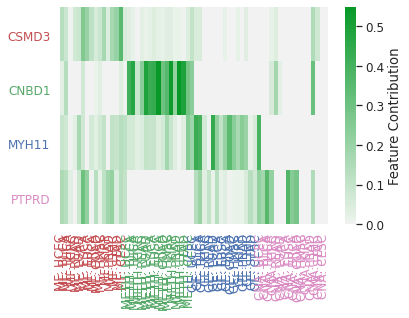

<Figure size 432x288 with 0 Axes>

In [135]:

from  sklearn.preprocessing import normalize
from tqdm import tqdm
#find cancer genes which specific omics type is important
cancer_idx = [] #compute cancer genes
for idx,label in enumerate(final_y[number_of_input_nodes:]):
    if(label==1):
        cancer_idx.append(idx)

number_of_input_nodes = batch.x.shape[0]


meta_node_feat_list = [] 
meta_tensor = []
for idx in tqdm(cancer_idx):

    output_idx = number_of_input_nodes + idx #TARGET NODE GENE to explain
    target = int(final_y[output_idx])
    if(target==0):
        label_gene = "non-cancer"
    else:
        label_gene = "cancer"
        
    with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_{label_gene}.pkl","rb") as handle:
        node_feat_mask = pickle.load(handle).squeeze(0)
    
    node_feat_mask = node_feat_mask.abs() #abs values
    ig_attr_node = node_feat_mask.abs().sum(dim=1)
    ig_attr_node /= ig_attr_node.max()
    #values,indices = ig_attr_node.sort(descending=True)
    
    meta_node_feat = node_feat_mask[output_idx]
    meta_tensor.append(meta_node_feat)
    meta_node_feat_list.append(np.array([torch.sum(meta_node_feat[0:16]),torch.sum(meta_node_feat[16:32]),torch.sum(meta_node_feat[32:48]),torch.sum(meta_node_feat[48:])]))


meta_tensor = torch.stack(meta_tensor)
meta_tensor_normalized  = torch.tensor(normalize(meta_tensor,axis=0))

# sort each column to find genes with the largest contribution of each omics type
meta_node_feat_list = np.array(meta_node_feat_list)
print("initial",meta_node_feat_list,"\n")
sorted_ind_0 = np.argsort(meta_node_feat_list[:, 0])
sorted_ind_1 = np.argsort(meta_node_feat_list[:, 1])
sorted_ind_2 = np.argsort(meta_node_feat_list[:, 2])
sorted_ind_3 = np.argsort(meta_node_feat_list[:, 3])

meta_node_feat_list_0 = meta_node_feat_list[sorted_ind_0]
meta_node_feat_list_1 = meta_node_feat_list[sorted_ind_1]
meta_node_feat_list_2 = meta_node_feat_list[sorted_ind_2]
meta_node_feat_list_3 = meta_node_feat_list[sorted_ind_3]

print("after",meta_node_feat_list_0[-5:],"\n")

i=1

indices = [sorted_ind_0[-2],sorted_ind_1[-i],sorted_ind_2[-i],sorted_ind_3[-i]]
plt.figure(figsize=(15,5))


y_nodenames_ind = [cancer_idx[ind]+number_of_input_nodes for ind in indices]


y_nodenames = all_node_names[y_nodenames_ind]
y_nodenames = [name.split("_")[0] for name in y_nodenames]


rdgn = sb.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)

node_feat_mask_list = []
print(indices)
for idx in indices:
    node_feat_mask_list.append(meta_tensor_normalized[idx])

        
node_feat_mask_tensor = torch.stack(node_feat_mask_list)

ax = sb.heatmap(node_feat_mask_tensor,cmap=rdgn,center=0.0,cbar_kws={'label': 'Feature Contribution'})

ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
my_colors = sb.color_palette()  

for i,ticklabel in enumerate(plt.gca().get_yticklabels()):
    if(i==0):
        idx = 3
    elif(i==1):
        idx = 2
    elif(i==2):
        idx=0
    else:
        idx = 6    
    ticklabel.set_color(my_colors[idx])

for i,ticklabel in enumerate(plt.gca().get_xticklabels()):
    if(i<16):
        idx =3
    elif(i>=16 and i<32):
        idx = 2
    elif(i>=32 and i<48):
        idx=0
    else:
        idx = 6
    ticklabel.set_color(my_colors[idx])

ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

trans = mtrans.Affine2D().translate(0, -50)
for t in ax.get_yticklabels():
    t.set_transform(t.get_transform()+trans)
    
#ax.set_title(f"Genes with largest feature contribution in each omics type")
plt.savefig(f"{model_dir}/explain/feat_contr_top_omics.pdf",bbox_inches="tight")
plt.show()
plt.clf()



## plot feature contributions of specific genes

100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


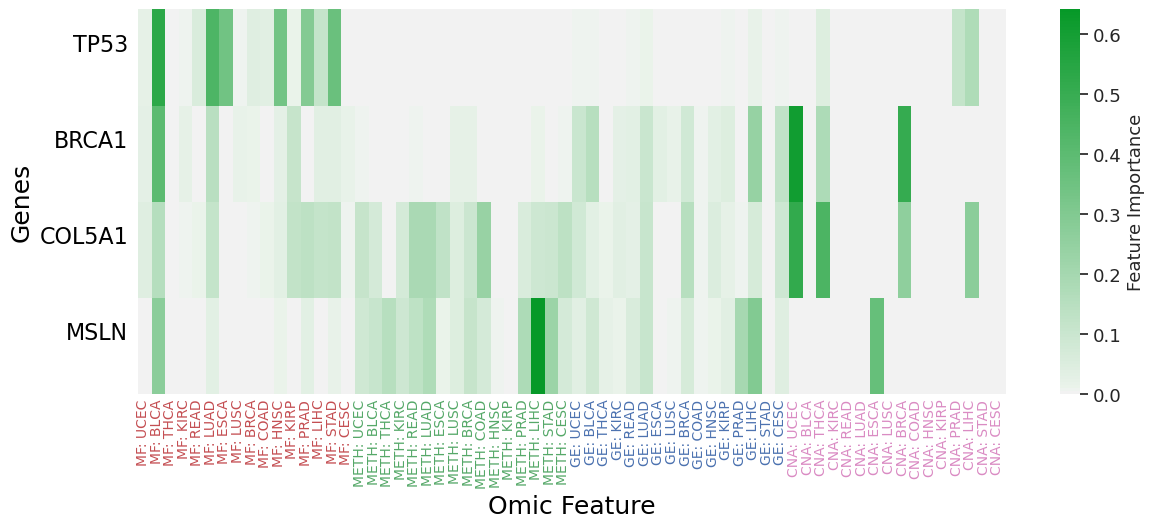

14.0 5.0


<Figure size 1400x500 with 0 Axes>

In [31]:
#MYH11,COL5A1,CSMD,MSLN
from tqdm import tqdm
import seaborn as sns
from  sklearn.preprocessing import normalize
import matplotlib.transforms as mtrans
import matplotlib
from matplotlib import rcParams
import seaborn as sns
from matplotlib import font_manager
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

specific_idx = []
inv_all_node_names = {v: i for i,v in enumerate(all_node_names)}

specific_idx.append(inv_all_node_names["TP53_Meta_Node"]-number_of_input_nodes)
specific_idx.append(inv_all_node_names["BRCA1_Meta_Node"]-number_of_input_nodes)
specific_idx.append(inv_all_node_names["COL5A1_Meta_Node"]-number_of_input_nodes)
specific_idx.append(inv_all_node_names["MSLN_Meta_Node"]-number_of_input_nodes)
meta_tensor = []
for idx in tqdm(specific_idx):
    output_idx = number_of_input_nodes + idx #TARGET NODE GENE to explain
    
    if(os.path.exists(f"{model_dir}/explain/node_feat_mask_explain_{idx}_cancer.pkl")):
        with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_cancer.pkl","rb") as handle:
            node_feat_mask = pickle.load(handle).squeeze(0)
    else:
        with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_top_predicted.pkl","rb") as handle:
            node_feat_mask = pickle.load(handle).squeeze(0)
    
    node_feat_mask = node_feat_mask.abs() #abs values
    ig_attr_node = node_feat_mask.abs().sum(dim=1)
    ig_attr_node /= ig_attr_node.max()
    #values,indices = ig_attr_node.sort(descending=True)
    
    meta_node_feat = node_feat_mask[output_idx]
    meta_tensor.append(meta_node_feat)


meta_tensor = torch.stack(meta_tensor)
meta_tensor_normalized  = torch.tensor(normalize(meta_tensor,axis=1))

y_nodenames = all_node_names[[s+number_of_input_nodes for s in specific_idx]]
y_nodenames = [name.split("_")[0] for name in y_nodenames]


rdgn = sb.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True) 


fig, ax = plt.subplots(figsize=(14, 5))



sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(font_scale = 1.1)
BIGGER_SIZE=13
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['xtick.top'] = False
rcParams['ytick.right'] = False
rcParams['figure.figsize'] = (14,5)

sb.heatmap(meta_tensor_normalized,cmap=rdgn,center=0.0,cbar_kws={'label': 'Feature Importance'})
ax.tick_params(left=False, bottom=False)

ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
my_colors = sb.color_palette()  
 

for i,ticklabel in enumerate(plt.gca().get_xticklabels()):
    if(i<16):
        idx =3
    elif(i>=16 and i<32):
        idx = 2
    elif(i>=32 and i<48):
        idx=0
    else:
        idx = 6
    ticklabel.set_color(my_colors[idx])

ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,fontsize=16)

#plt.xticks(fontsize=18)
trans = mtrans.Affine2D().translate(0, -35)
for t in ax.get_yticklabels():
    t.set_transform(t.get_transform()+trans)
    
trans = mtrans.Affine2D().translate(5, 5)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.xlabel("Omic Feature",fontsize=18)
plt.ylabel("Genes",fontsize=18)
#ax.set_title(f"Genes with largest feature contribution in each omics type")
plt.savefig(f"{model_dir}/explain/feat_contr_specific_omics.pdf",bbox_inches="tight")
plt.show()

fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)

plt.clf()



In [10]:
f"{model_dir}/explain/feat_contr_specific_omics.pdf"

"./results/my_models/GCN_['IREF_2015', 'PCNET', 'IREF', 'STRING', 'MULTINET', 'CPDB']_2023_01_02_16_59_31/explain/feat_contr_specific_omics.pdf"

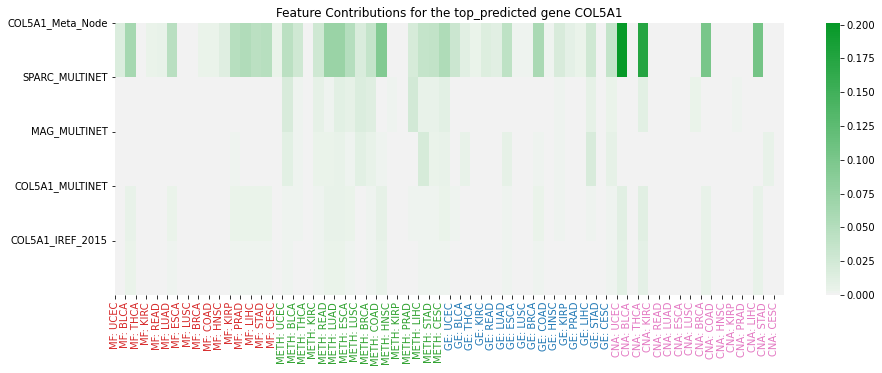

<Figure size 432x288 with 0 Axes>

In [5]:

# feature contributions for cancer genes
cancer_idx = []
for idx,label in enumerate(final_y[number_of_input_nodes:]):
    if(label==1):
        cancer_idx.append(idx)

for idx in [22510, 14876, 22388, 22510]:
    number_of_input_nodes = batch.x.shape[0]
    output_idx = number_of_input_nodes + idx #TARGET NODE GENE to explain
    target = int(final_y[output_idx])
    if(target==0):
        label_gene = "non-cancer"
    else:
        label_gene = "cancer"

    with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_{label_gene}.pkl","rb") as handle:
        node_feat_mask = pickle.load(handle).squeeze(0)
    
    node_feat_mask = node_feat_mask.abs() #abs values
    ig_attr_node = node_feat_mask.abs().sum(dim=1)
    ig_attr_node /= ig_attr_node.max()
    values,indices = ig_attr_node.sort(descending=True)
     
    plt.figure(figsize=(15,5))
    rows = 5
    y_nodenames = all_node_names[indices[:rows]]

    rdgn = sb.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)


    ax = sb.heatmap(node_feat_mask[indices[:rows]],cmap=rdgn,center=0.00)
    ax.set_xticks(range(len(features_order))) # <--- set the ticks first
    ax.set_xticklabels(features_order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    

    my_colors = sb.color_palette()  
    for i,ticklabel in enumerate(plt.gca().get_xticklabels()):
        if(i<16):
            idx =3
        elif(i>=16 and i<32):
            idx = 2
        elif(i>=32 and i<48):
            idx=0
        else:
            idx = 6
        ticklabel.set_color(my_colors[idx])
    
    ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
    ax.set_yticklabels(y_nodenames)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.set_title(f"Feature Contributions for the {label_gene} gene {all_node_names[output_idx].split('_')[0]}")
    plt.savefig(f"{model_dir}/explain/heatmap_{idx}.pdf",bbox_inches="tight")
    plt.show()
    
    plt.clf()

In [163]:

#Compute Biclustering
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering,AgglomerativeClustering
from sklearn.metrics import consensus_score

#Compute idx for cancer and non-cancer genes
cancer_idx = []
for idx,label in enumerate(final_y[number_of_input_nodes:]):
    if(label==1):
        cancer_idx.append(idx)

print("Number of cancer genes",len(cancer_idx))

non_cancer_idx = []
for idx,label in enumerate(final_y[number_of_input_nodes:]):
    if(label==0):
        non_cancer_idx.append(idx) 

print("Number of non-cancer genes",len(non_cancer_idx))

feat_contr = []
y_nodenames = []
for idx in cancer_idx:
    with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_cancer.pkl","rb") as handle:
        node_feat_mask = pickle.load(handle).squeeze(0)

    number_of_input_nodes = batch.x.shape[0]
    output_idx = number_of_input_nodes + idx #TARGET NODE GENE to explain
    target = int(final_y[output_idx])

    ig_attr_node = node_feat_mask.abs().sum(dim=1)
    ig_attr_node /= ig_attr_node.max()
    values,indices = ig_attr_node.sort(descending=True)
    feat_contr.append(node_feat_mask[indices[0]].detach().numpy())
    y_nodenames.append(all_node_names[indices[0]])
y_nodenames = np.array(y_nodenames)

Number of cancer genes 887
Number of non-cancer genes 21772


<Figure size 432x288 with 0 Axes>

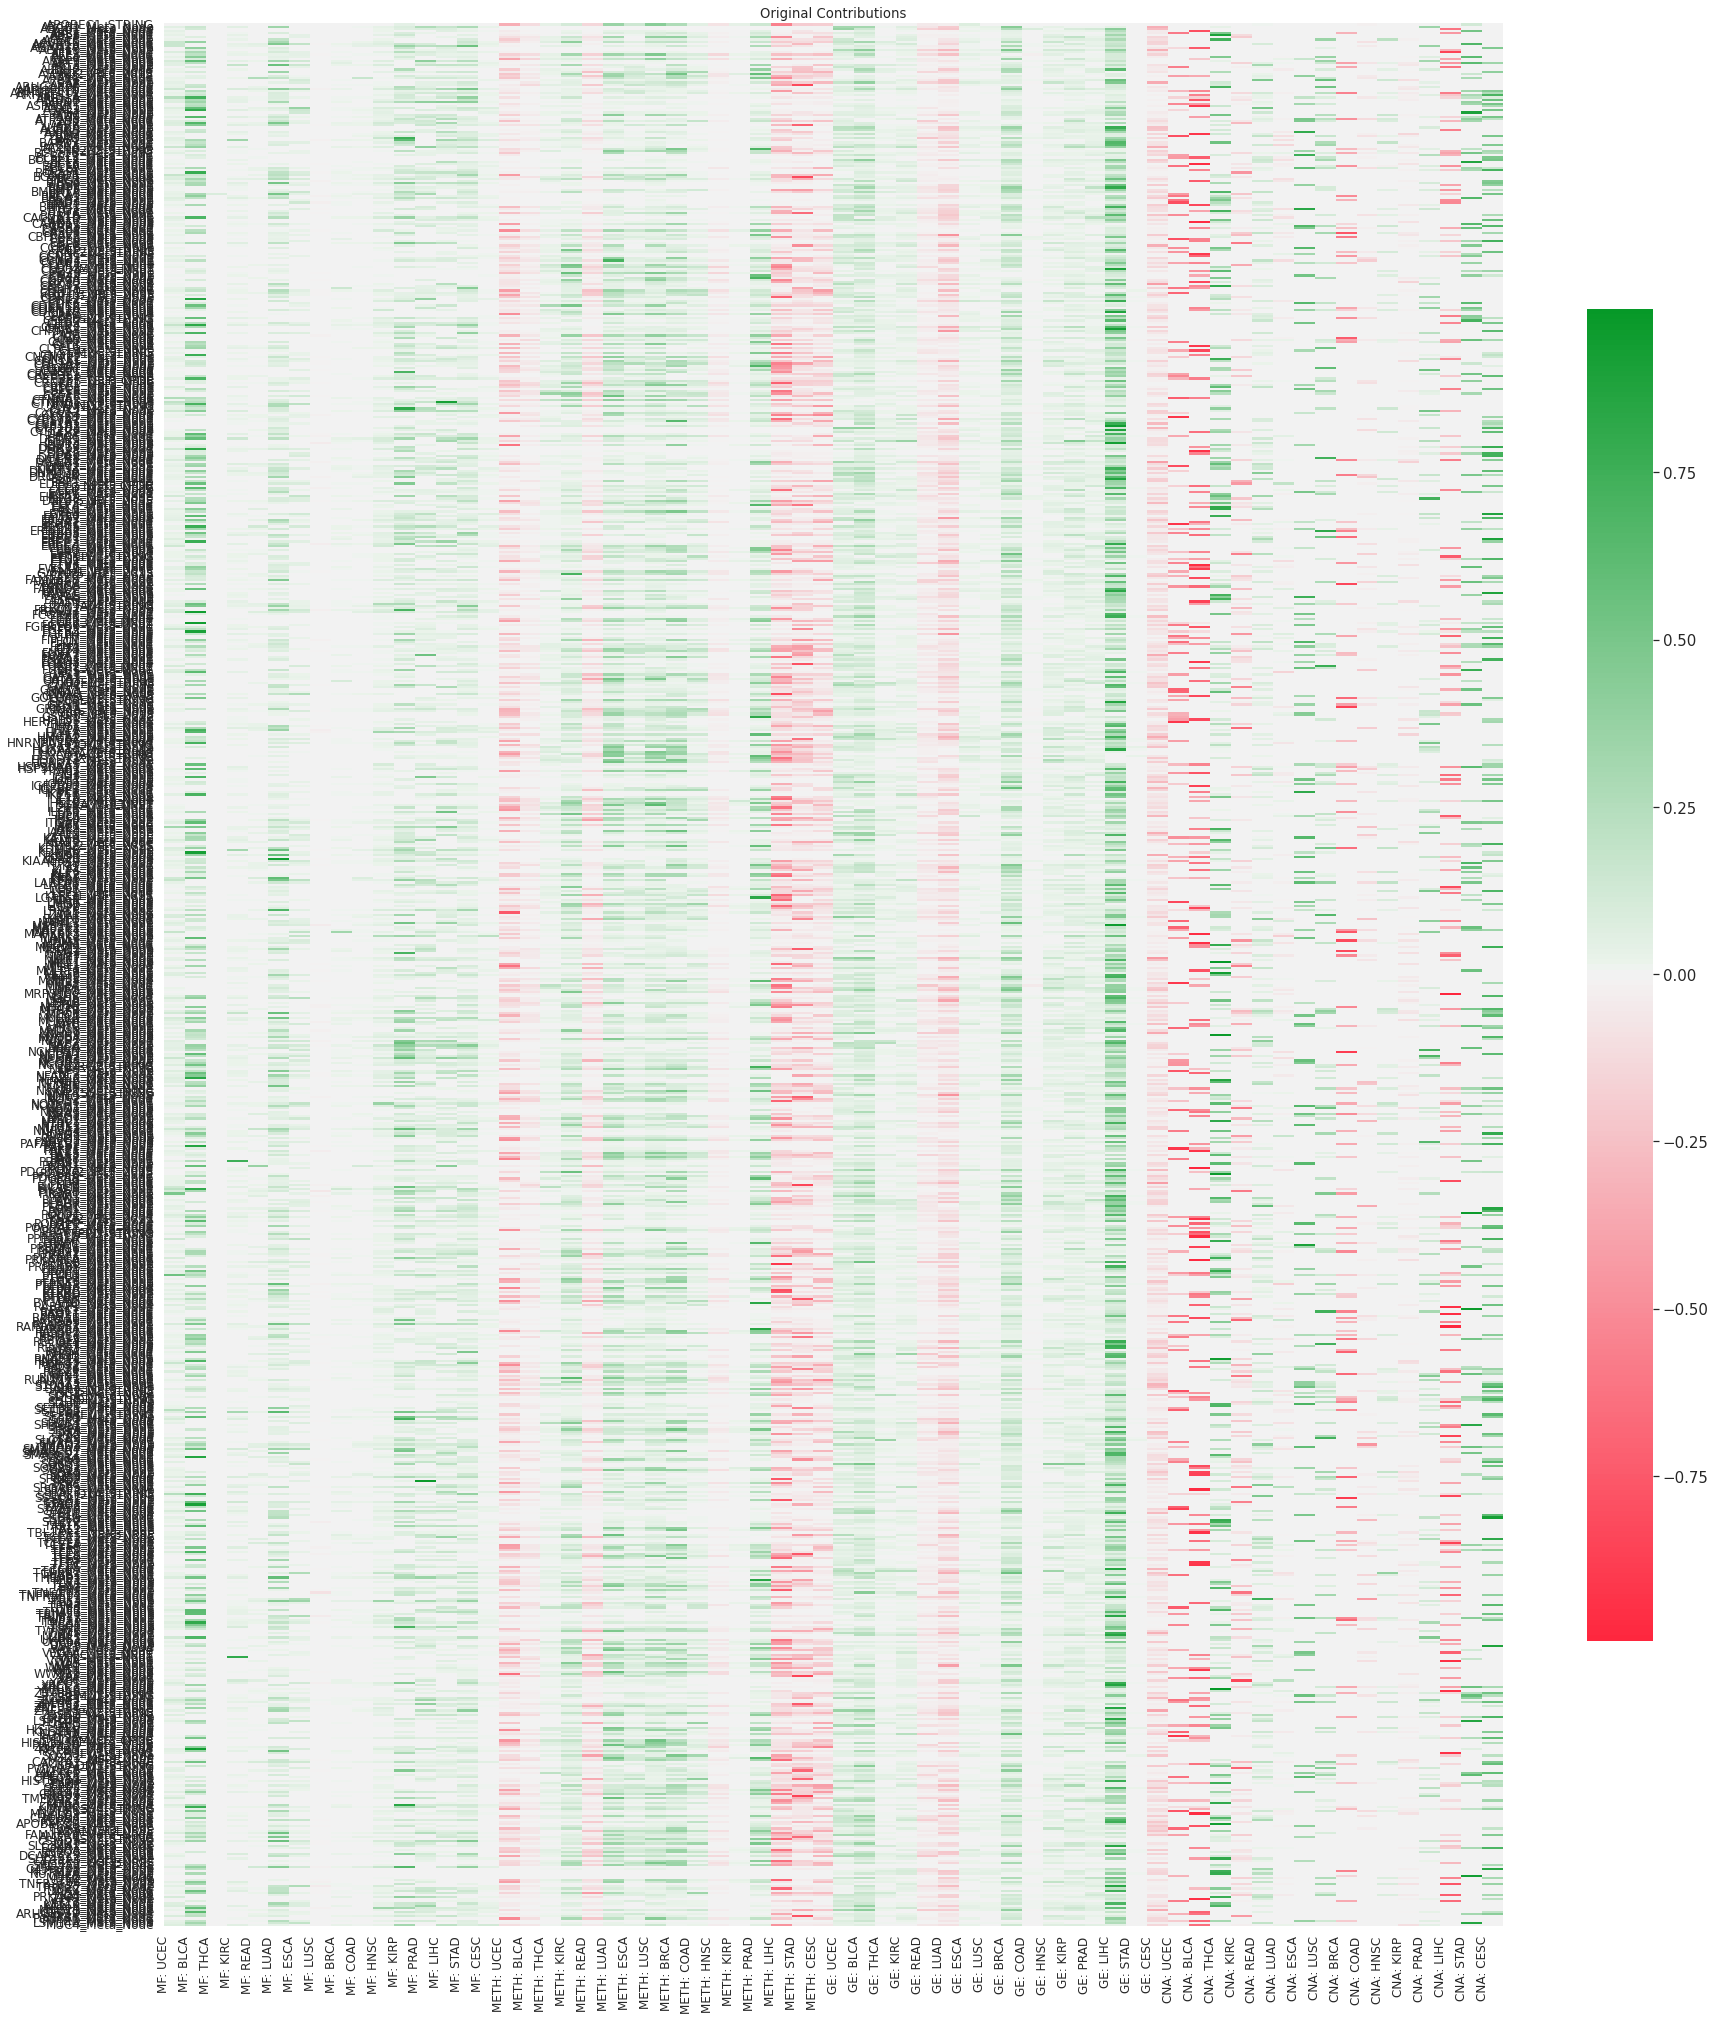

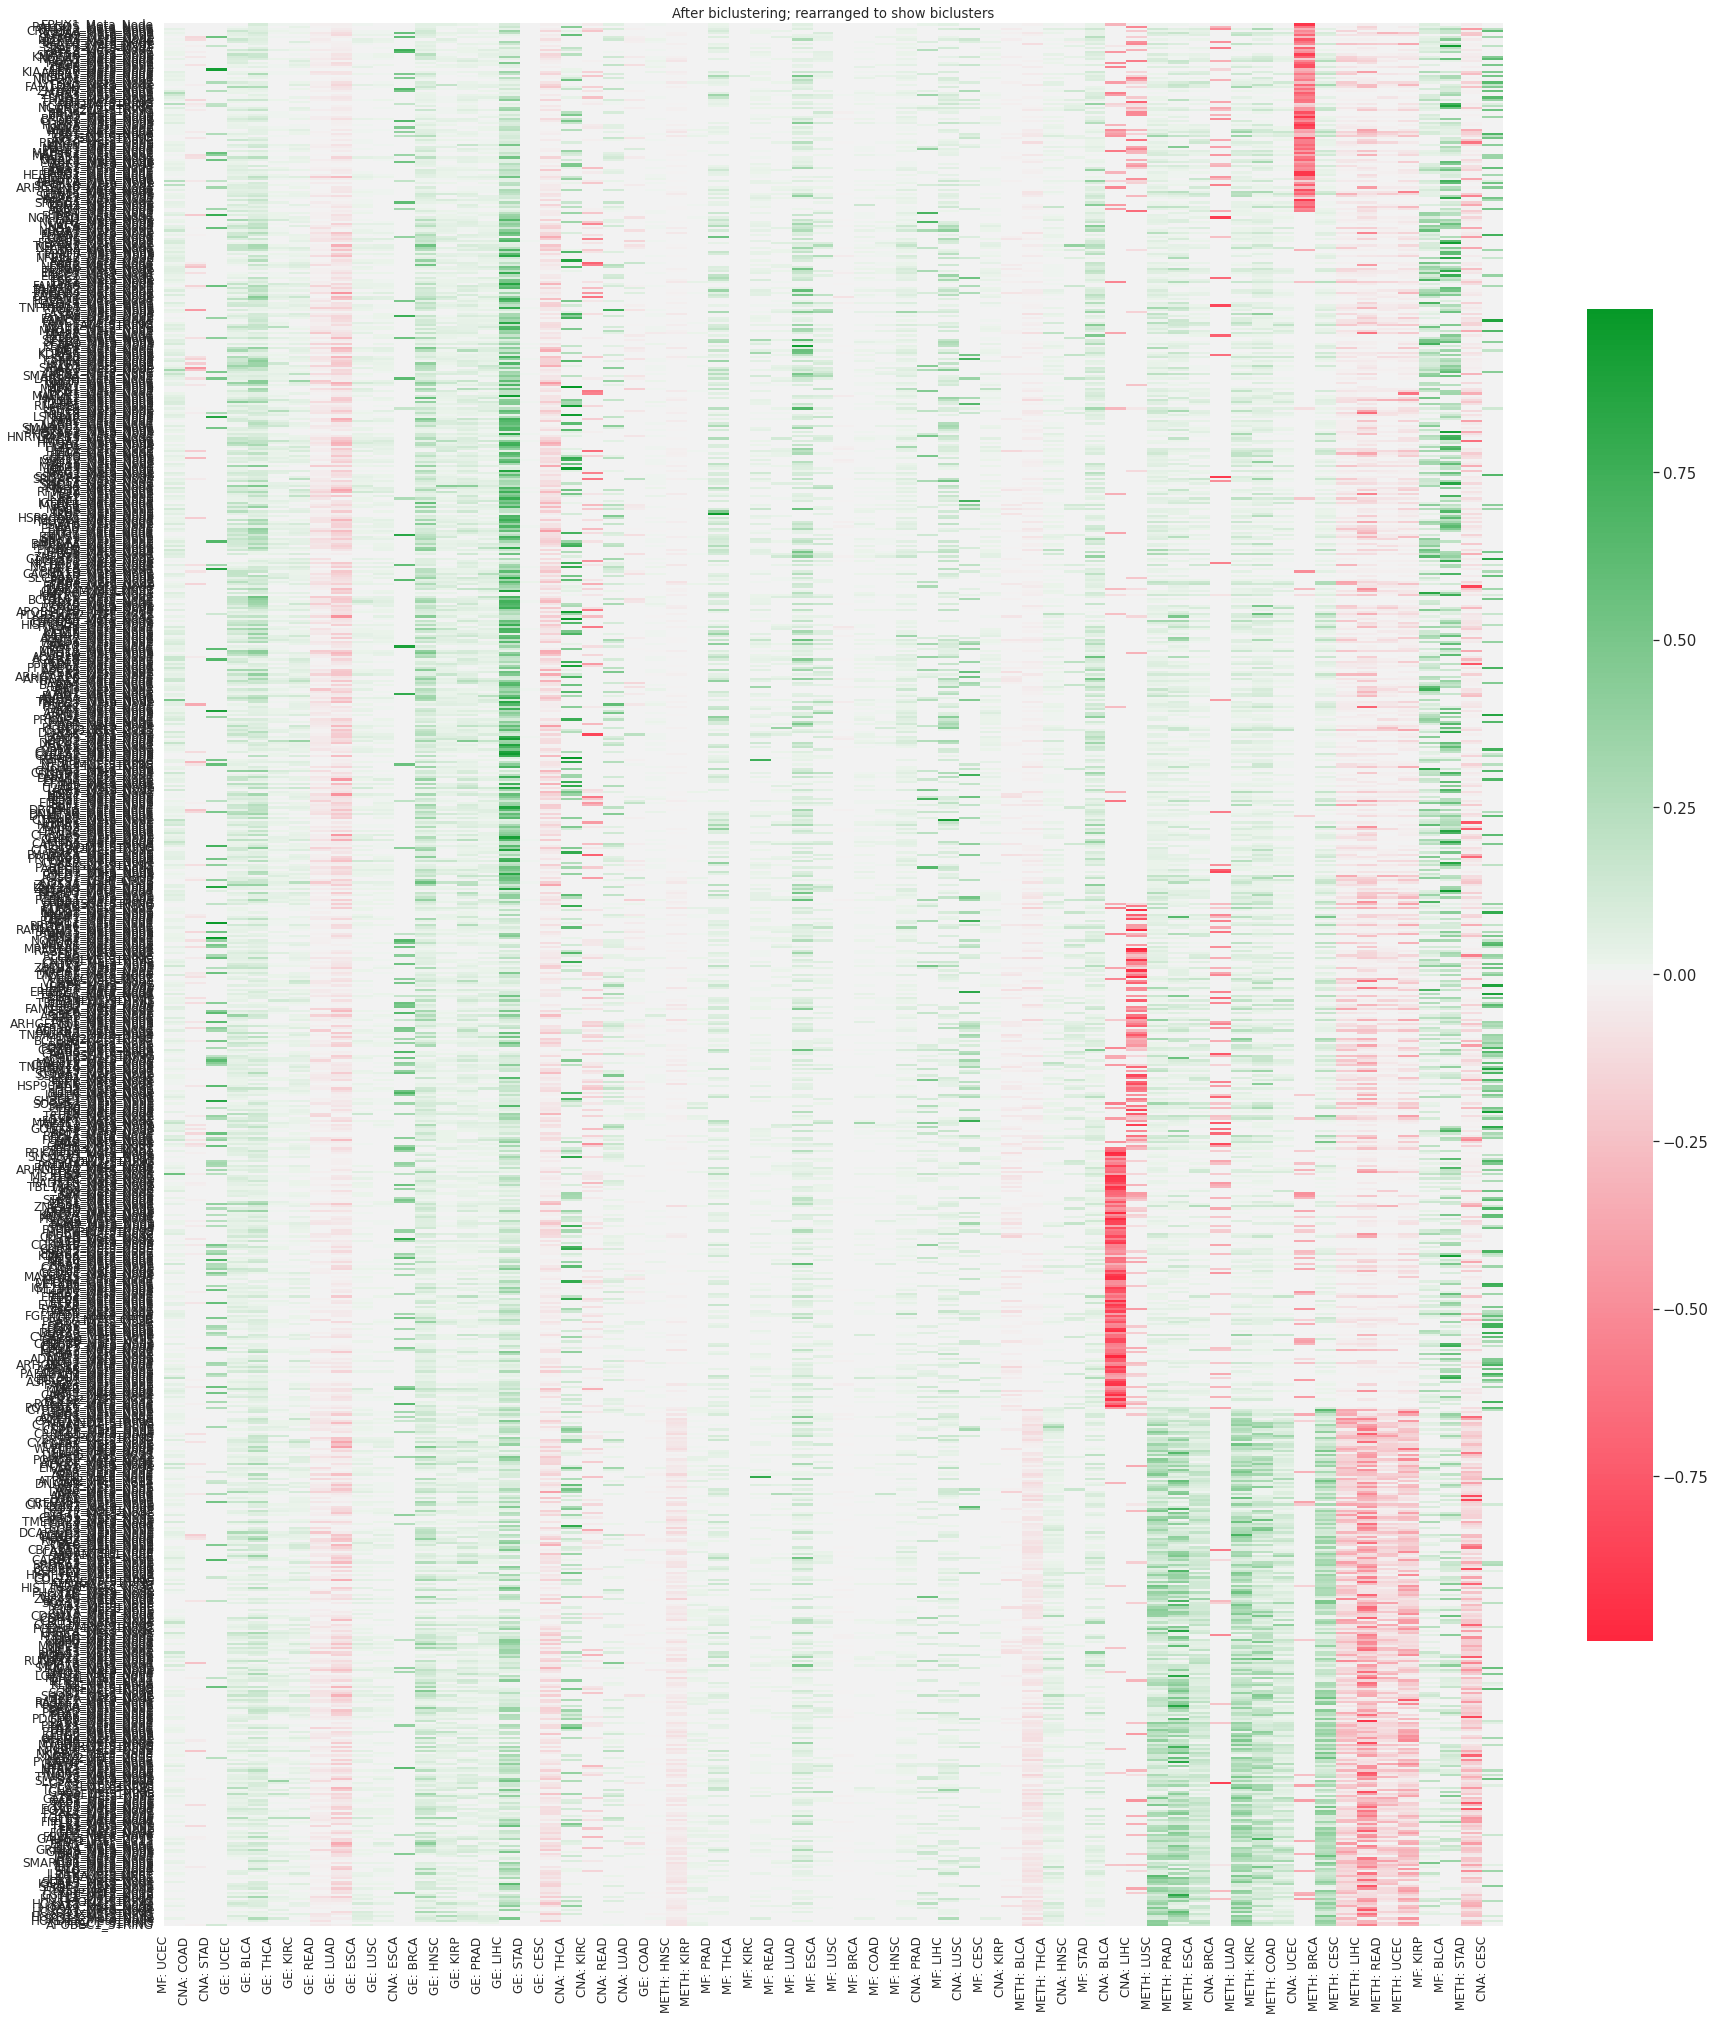

/mnt/home/mchatzianastasi/miniconda3/envs/cancerenv1/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2160x2880 with 0 Axes>

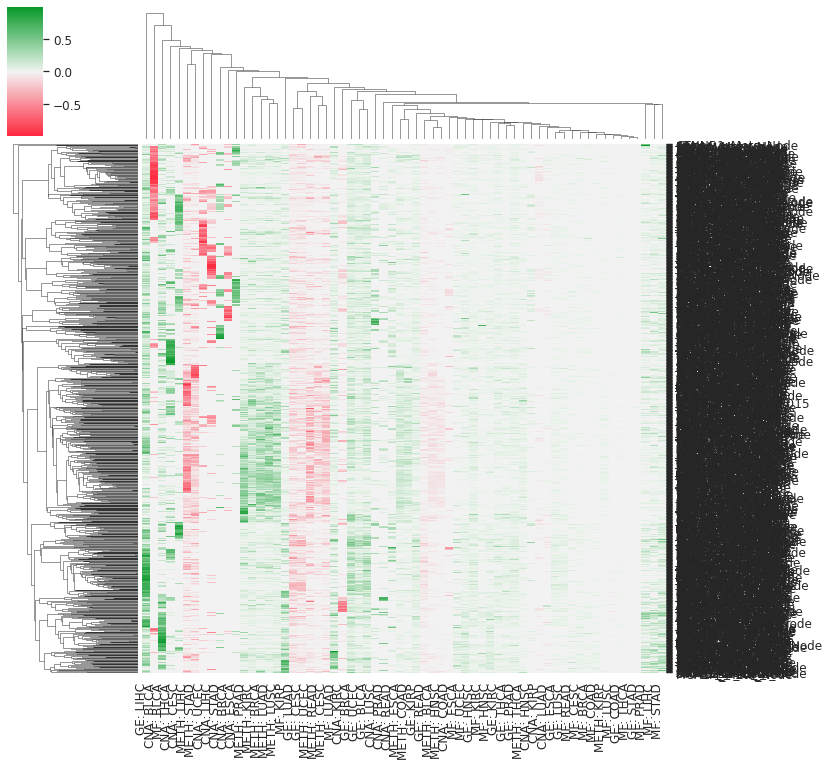

In [164]:

from  sklearn.preprocessing import normalize
#Visualize biclustering feature contributions
plt.clf()

feat_contr = np.array(feat_contr)

feat_contr = normalize(feat_contr)
rdgn = sb.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)

n_clusters = (5, 4)
fig = plt.figure(figsize=(30,35))
ax = sb.heatmap(feat_contr, cmap=rdgn,cbar_kws={"shrink": .7})
ax.figure.axes[-1].tick_params(labelsize=15)

ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Original Contributions")
plt.savefig(f"{model_dir}/explain/cancer_genes_node_feat_original.pdf",bbox_inches="tight")
plt.show()


model = SpectralBiclustering(n_clusters=n_clusters, method="log", random_state=0)
#model = AgglomerativeClustering(n_clusters=n_clusters)
model.fit(feat_contr)


row_ind = np.argsort(model.row_labels_)
col_ind = np.argsort(model.column_labels_)
fit_data = feat_contr[row_ind]
fit_data = fit_data[:, col_ind]


fig = plt.figure(figsize=(30,35))
ax = sb.heatmap(fit_data, cmap=rdgn,cbar_kws={"shrink": .7})
ax.figure.axes[-1].tick_params(labelsize=15)

ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order[col_ind])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames[row_ind])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("After biclustering; rearranged to show biclusters")
plt.savefig(f"{model_dir}/explain/cancer_genes_node_feat_biclustering.pdf",bbox_inches="tight")
plt.show()


fig = plt.figure(figsize=(30,40))
g = sb.clustermap(feat_contr,cmap=rdgn)
row_ind = g.dendrogram_row.reordered_ind
col_ind = g.dendrogram_col.reordered_ind
ax = g.ax_heatmap
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order[col_ind])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames[row_ind])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.savefig(f"{model_dir}/explain/cancer_genes_node_feat_clustermap.pdf",bbox_inches="tight")
plt.show()


## edge feat mask explain

[16948, 14876, 22388, 22510]
tensor([54192,  2254, 87782,  ..., 67646, 67647, 67648])


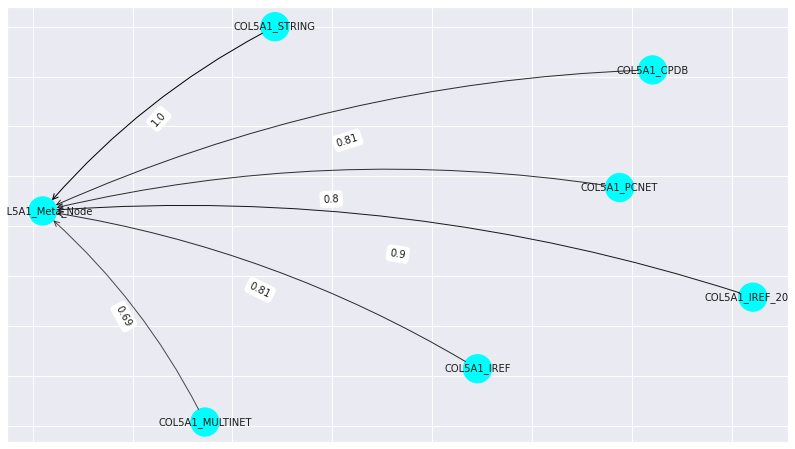

tensor([ 6511, 51035, 26838,  ..., 67645, 67646, 67647])


<Figure size 432x288 with 0 Axes>

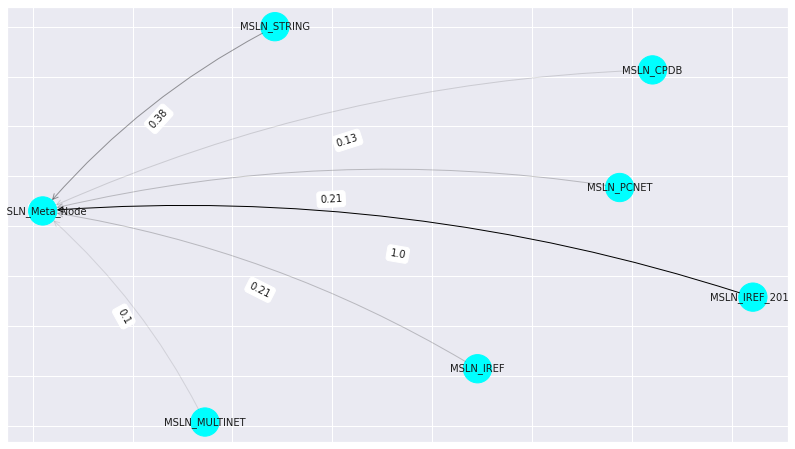

tensor([50315, 77954,  3018,  ..., 67646, 67647, 67648])


<Figure size 432x288 with 0 Axes>

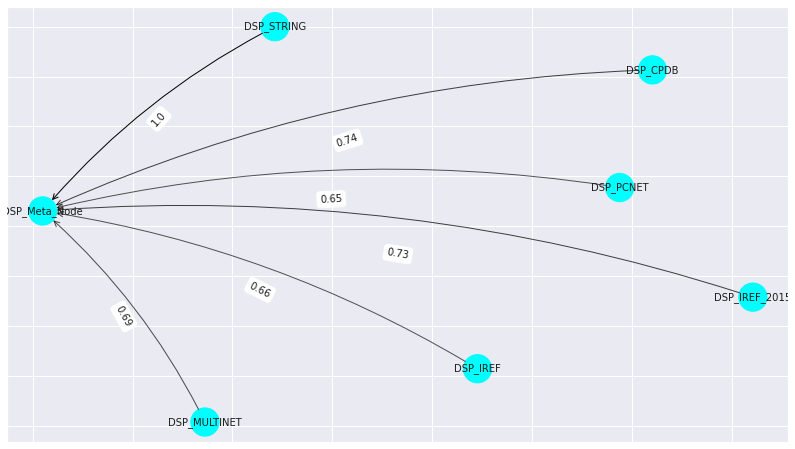

tensor([61936, 69956,  6528,  ..., 67645, 67646, 67647])


<Figure size 432x288 with 0 Axes>

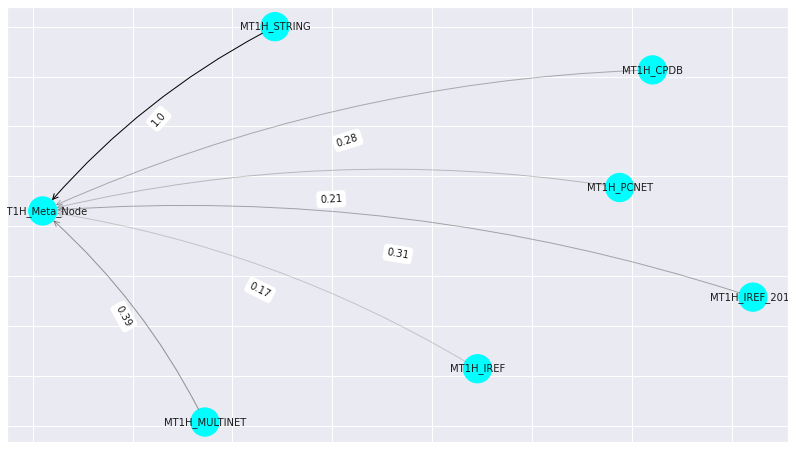

tensor([73004, 49020,  9295,  ..., 67645, 67646, 67647])


<Figure size 432x288 with 0 Axes>

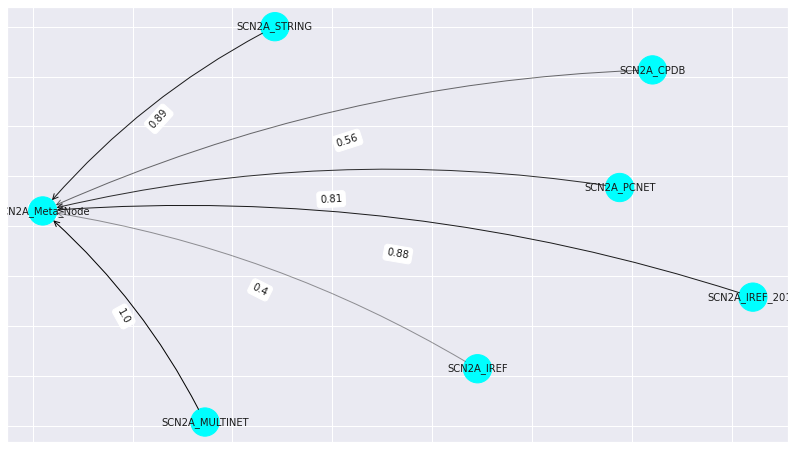

<Figure size 432x288 with 0 Axes>

In [104]:
from captum_custom import to_captum,Explainer
model = MultiFrameworkGNN(batch.x.shape[1],
                    args.hidden,
                    args.n_layers,
                    nclass=2,
                    args=args,
                    data=batch,
                    meta_x=meta_x,
                    node2idx=node2idx)
explainer = Explainer(model)

print(ind)
for i in [2254,6511,3018,6528,9295]:
    idx = i + number_of_input_nodes
    with open(f"{model_dir}/explain/edge_mask_explain_{i}_top_predicted.pkl","rb") as handle:
        edge_mask_explain = pickle.load(handle).squeeze(0)
        
    ig_attr_edge = edge_mask_explain.squeeze(0).abs()
    ig_attr_edge /= ig_attr_edge.max()
    values, indices = ig_attr_edge.sort(descending=True)
    print(indices)
    node_dict = {i:n for i,n in enumerate(all_node_names)}
    plt.figure(figsize=(14,8))
    ax, G = explainer.visualize_subgraph(idx, meta_edge_index, ig_attr_edge,y=final_y,labels=node_dict)
    plt.savefig(f"{model_dir}/explain/captum_node_{i}_cancer.pdf",bbox_inches="tight")
    plt.show()
    plt.clf()

In [409]:
inv_all_node_names = {v: i for i,v in enumerate(all_node_names)}
meta_edge_index[:,197202]
all_node_names[107075]

'CSMD3_Meta_Node'

[10921, 1069, 2254, 12838]
tensor([101048]) TP53_Meta_Node 1.0
second_max tensor([1.2958, 0.6314], dtype=torch.float64, grad_fn=<TopkBackward0>)
tensor([76589]) TP53_CPDB 0.0
tensor([74978]) TP53_MULTINET 0.0
tensor([51408]) TP53_STRING 0.0
tensor([33160]) TP53_IREF 0.0
tensor([12350]) TP53_PCNET 0.0
tensor([10921]) TP53_IREF_2015 0.0
tensor([91196]) BRCA1_Meta_Node 0.2375130672182428
tensor([76545]) BRCA1_CPDB 0.0
tensor([63263]) BRCA1_MULTINET 0.0
tensor([51963]) BRCA1_STRING 0.0
tensor([33288]) BRCA1_IREF 0.0
tensor([14828]) BRCA1_PCNET 0.0
tensor([1069]) BRCA1_IREF_2015 0.0
tensor([92381]) COL5A1_Meta_Node 0.6574022715156085
tensor([87782]) COL5A1_CPDB 0.0
tensor([64870]) COL5A1_MULTINET 0.0
tensor([54192]) COL5A1_STRING 0.0
tensor([33625]) COL5A1_IREF 0.0
tensor([21561]) COL5A1_PCNET 0.0
tensor([2254]) COL5A1_IREF_2015 0.0
tensor([102965]) H3F3A_Meta_Node 0.12757975274619157
tensor([78577]) H3F3A_CPDB 0.0
tensor([67370]) H3F3A_MULTINET 0.0
tensor([15731]) H3F3A_PCNET 0.0


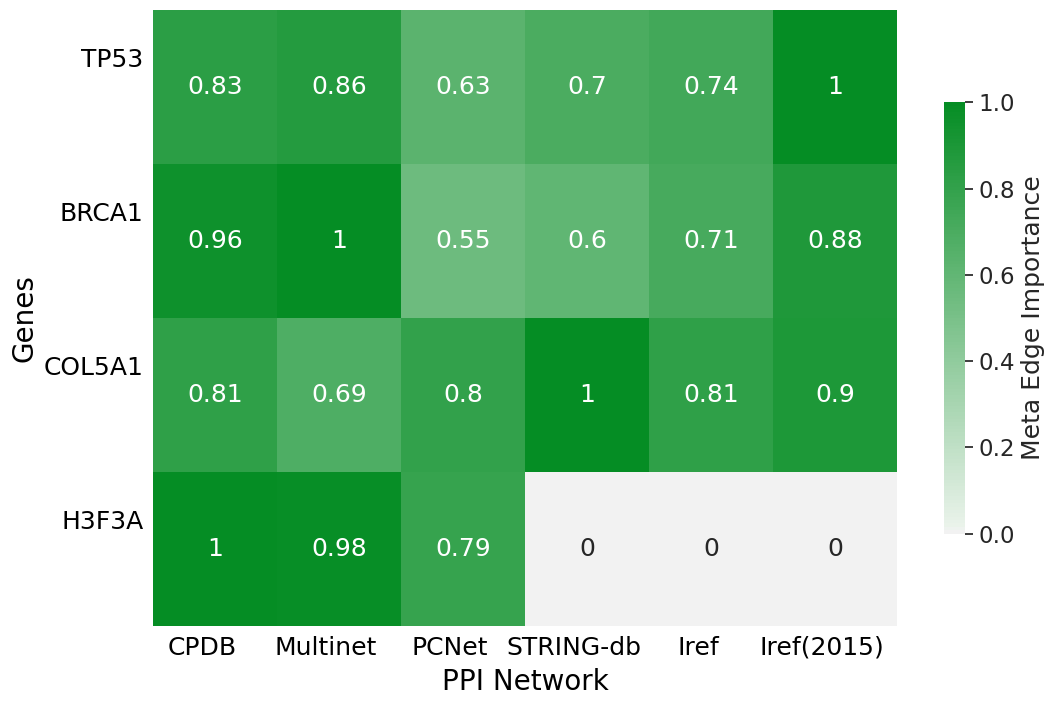

<Figure size 1200x800 with 0 Axes>

In [35]:
#Explain for 
import matplotlib
from matplotlib import rcParams
from matplotlib import font_manager
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.transforms as mtrans

graph_explain = {}
edge_contr = []

inv_all_node_names = {v: i for i,v in enumerate(all_node_names)}
ind = []
ind.append(inv_all_node_names["TP53_Meta_Node"]-number_of_input_nodes)
ind.append(inv_all_node_names["BRCA1_Meta_Node"]-number_of_input_nodes)
ind.append(inv_all_node_names["COL5A1_Meta_Node"]-number_of_input_nodes)
ind.append(inv_all_node_names["H3F3A_Meta_Node"]-number_of_input_nodes)

print(ind)

graphs = ["CPDB","Multinet","PCNet","STRING-db","Iref","Iref(2015)"]
y_nodenames =[]
for i in ind:
    if(os.path.exists(f"{model_dir}/explain/edge_mask_explain_{i}_cancer.pkl")):
        with open(f"{model_dir}/explain/edge_mask_explain_{i}_cancer.pkl","rb") as handle:
            edge_mask_explain = pickle.load(handle).squeeze(0)
    else:
        with open(f"{model_dir}/explain/edge_mask_explain_{i}_top_predicted.pkl","rb") as handle:
            edge_mask_explain = pickle.load(handle).squeeze(0)
    
    output_idx = number_of_input_nodes + i #TARGET NODE GENE to explain
    target = int(final_y[output_idx])
    if(target==0):
        label_gene = "non-cancer"
    else:
        label_gene = "cancer"
    ig_attr_edge = edge_mask_explain.squeeze(0).abs()
    ig_attr_edge /= ig_attr_edge.max()
    sorted_values,indices = ig_attr_edge.sort(descending=True)
    non_zero_idx = np.nonzero(edge_mask_explain)
    not_added_names = ["CPDB","IREF_2015","PCNET","STRING","MULTINET","IREF"]
    non_zero_idx = meta_edge_index[0,non_zero_idx]
    for idx in non_zero_idx.sort(descending=True,axis=0)[0]:
        print(idx,all_node_names[idx],ig_attr_edge[idx+number_of_input_nodes].item())
        if(idx>=number_of_input_nodes):
            if(ig_attr_edge[idx+number_of_input_nodes].item()==1):
                ig_attr_edge = edge_mask_explain.squeeze(0).abs()
                second_max,_ = torch.topk(ig_attr_edge,2)
                print("second_max",second_max)
                ig_attr_edge /= second_max[1].item()
            continue
        name = all_node_names[idx].split("_",1)[-1]
        graph_explain[name] = ig_attr_edge[idx].item()
        not_added_names.remove(name)
    for name in not_added_names:
        graph_explain[name]=0

    edge_contr.append([graph_explain["CPDB"],graph_explain["MULTINET"],
                      graph_explain["PCNET"],graph_explain["STRING"],
                      graph_explain["IREF"],graph_explain["IREF_2015"]])
    y_nodenames.append(all_node_names[output_idx].split("_")[0])
        
rdgn = sb.diverging_palette(h_neg=30, h_pos=130, s=99, l=51, sep=3, as_cmap=True)


fig, ax=plt.subplots(1,1, figsize=(12,8))


sns.set_style("whitegrid")
sns.set_context("paper")
BIGGER_SIZE=14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['xtick.top'] = False
rcParams['ytick.right'] = False
rcParams['figure.figsize'] = (12,8)
plt.tick_params(left = False, bottom = False)

sb.set(font_scale = 1.5)

sb.heatmap(edge_contr, annot=True, cmap=rdgn, center=0, cbar_kws={"shrink": .7,"label": 'Meta Edge Importance'})

ax.figure.axes[-1].tick_params()

ax.set_xticks(range(len(graphs))) # <--- set the ticks first
ax.set_xticklabels(graphs)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=18)

plt.xlabel("PPI Network",fontsize=20,labelpad=6)
plt.ylabel("Genes",fontsize=20)


trans = mtrans.Affine2D().translate(24, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,fontsize=18)

trans = mtrans.Affine2D().translate(0, -50)
for t in ax.get_yticklabels():
    t.set_transform(t.get_transform()+trans)
    
trans = mtrans.Affine2D().translate(+25, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
plt.savefig(f"{model_dir}/explain/edge_feat_contr_examples.pdf")
plt.show()
plt.clf()


In [382]:
"CSMD3_Iref(2015)" in all_node_names

False

/tmp/ipykernel_43259/4095432840.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals = np.array(list(graph_explain.values()))


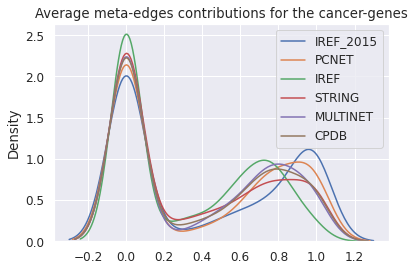

mean values
IREF_2015 mean:  0.40871449428540724 std:  0.43594251198544476
PCNET mean:  0.39162806871973016 std:  0.4170233018056409
IREF mean:  0.3226392781832922 std:  0.3559960374631907
STRING mean:  0.3466085211482482 std:  0.3908942640276594
MULTINET mean:  0.3656694531828819 std:  0.3951174380616172
CPDB mean:  0.36323691640353034 std:  0.39525059579243865


<Figure size 432x288 with 0 Axes>

In [38]:
from itertools import chain
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering
from itertools import chain
from  sklearn.preprocessing import normalize

#Explain for cancer genes
graph_explain = {}
y_nodenames = []

for idx in cancer_idx:
    with open(f"{model_dir}/explain/edge_mask_explain_{idx}_cancer.pkl","rb") as handle:
        edge_mask_explain = pickle.load(handle).squeeze(0)

    ig_attr_edge = edge_mask_explain.squeeze(0).abs()
    ig_attr_edge /= ig_attr_edge.max()
    sorted_values,indices = ig_attr_edge.sort(descending=True)
    non_zero_idx = np.nonzero(edge_mask_explain)
    #not_added_names = ["CPDB","IREF_2015","PCNET","STRING","MULTINET","IREF"]
    not_added_names = []
    non_zero_idx = meta_edge_index[0,non_zero_idx]
    for idx in non_zero_idx:
        name = all_node_names[idx].split("_",1)[-1]
        if(name in graph_explain):
            graph_explain[name].append(ig_attr_edge[idx].item())
        else:
            graph_explain[name] = [ig_attr_edge[idx].item()]
        not_added_names.append(name)
    for name in not_added_names:
        graph_explain[name].append(0) 
    y_nodenames.append(all_node_names[idx].split("_",1)[0])

y_nodenames = np.array(y_nodenames)
keys = list(graph_explain.keys())
# get values in the same order as keys, and parse percentage values
vals = np.array(list(graph_explain.values()))
vals_concat = list(chain(*vals))
graph_names =  []
for i,key in enumerate(graph_explain.keys()):
    graph_names.append([key for j in range(len(vals[i]))])
graph_names = list(chain(*graph_names))
data = pd.DataFrame({"edge_weight": vals_concat,"graph": graph_names})
                               
sb.kdeplot(vals[0],label=list(graph_explain.keys())[0])
sb.kdeplot(vals[1],label=list(graph_explain.keys())[1])
sb.kdeplot(vals[2],label=list(graph_explain.keys())[2])
sb.kdeplot(vals[3],label=list(graph_explain.keys())[3])
sb.kdeplot(vals[4],label=list(graph_explain.keys())[4])
sb.kdeplot(vals[5],label=list(graph_explain.keys())[5])
plt.title("Average meta-edges contributions for the cancer-genes")
plt.legend()
plt.savefig(f"{model_dir}/explain/average_meta_edge_cancer_genes_contributions.pdf",bbox_inches="tight")
plt.show()
plt.clf()
print("mean values")
print(list(graph_explain.keys())[0],"mean: ",np.array(vals[0]).mean(),"std: ",np.array(vals[0]).std())
print(list(graph_explain.keys())[1],"mean: ",np.array(vals[1]).mean(),"std: ",np.array(vals[1]).std())
print(list(graph_explain.keys())[2],"mean: ",np.array(vals[2]).mean(),"std: ",np.array(vals[2]).std())
print(list(graph_explain.keys())[3],"mean: ",np.array(vals[3]).mean(),"std: ",np.array(vals[3]).std())
print(list(graph_explain.keys())[4],"mean: ",np.array(vals[4]).mean(),"std: ",np.array(vals[4]).std())
print(list(graph_explain.keys())[5],"mean: ",np.array(vals[5]).mean(),"std: ",np.array(vals[5]).std())


In [39]:
#Compute Biclustering
number_of_elements = len(graph_explain[list(graph_explain.keys())[5]])
print(number_of_elements)
data = np.empty((6,number_of_elements))
for i in range(6):
    key = list(graph_explain.keys())[i]
    data[i] = graph_explain[key]
data = np.array(data)
data = np.reshape(data,(len(data[0]),6))

n_clusters= (6,2)
model = SpectralBiclustering(n_clusters=n_clusters, method="log", random_state=0)
model.fit(data)

#Visualize biclustering feature contributions
plt.clf()
fig = plt.figure(figsize=(30,30))

feat_contr = np.array(data)

#feat_contr = normalize(feat_contr)
#rdgn = sb.diverging_palette(h_neg=60, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
rdgn = "Greens"

ax = sb.heatmap(feat_contr, cmap=rdgn, cbar_kws={"shrink": .7})
features_order = np.array(list((graph_explain.keys())))
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Original Contributions")
plt.savefig(f"{model_dir}/explain/cancer_genes_edge_feat_original.pdf",bbox_inches="tight")
plt.show()

row_ind = np.argsort(model.row_labels_)
col_ind = np.argsort(model.column_labels_)
fit_data = feat_contr[row_ind]
fit_data = fit_data[:, col_ind]


fig = plt.figure(figsize=(30,30))
ax = sb.heatmap(fit_data, cmap=rdgn, cbar_kws={"shrink": .7})
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order[col_ind])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames[row_ind])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("After biclustering; rearranged to show biclusters")
plt.savefig(f"{model_dir}/explain/cancer_genes_edge_feat_biclustering.pdf",bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(30,30))
g = sb.clustermap(feat_contr,cmap=rdgn)
row_ind = g.dendrogram_row.reordered_ind
col_ind = g.dendrogram_col.reordered_ind
ax = g.ax_heatmap
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order[col_ind])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames[row_ind])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.savefig(f"{model_dir}/explain/cancer_genes_edge_feat_clustermap.pdf",bbox_inches="tight")


1600


ValueError: could not broadcast input array from shape (1578,) into shape (1600,)

In [36]:
#NON CANCER GENES
graph_explain = {}
for idx in non_cancer_idx:
    with open(f"{model_dir}/explain/edge_mask_explain_{idx}_non-cancer.pkl","rb") as handle:
        edge_mask_explain = pickle.load(handle).squeeze(0)

    ig_attr_edge = edge_mask_explain.squeeze(0).abs()
    ig_attr_edge /= ig_attr_edge.max()
    sorted_values,indices = ig_attr_edge.sort(descending=True)
    #for idx,v in enumerate(sorted_values[:6]): # we use 6 datasets-graphs
    non_zero_idx = np.nonzero(edge_mask_explain)
    not_added_names = ["CPDB","IREF_2015","PCNET","STRING","MULTINET","IREF"]

    for idx in non_zero_idx:
        name = all_node_names[idx].split("_",1)[-1]
        if(name in graph_explain):
            graph_explain[name].append(ig_attr_edge[idx].item())
        else:
            graph_explain[name] = [ig_attr_edge[idx].item()]
        not_added_names.remove(name)
    for name in not_added_names:
        graph_explain[name].append(0) 

keys = list(graph_explain.keys())
# get values in the same order as keys, and parse percentage values
vals = np.array(list(graph_explain.values()))
vals_concat = list(chain(*vals))
graph_names =  []
for i,key in enumerate(graph_explain.keys()):
    graph_names.append([key for j in range(len(vals[i]))])
graph_names = list(chain(*graph_names))
data = pd.DataFrame({"edge_weight": vals_concat,"graph": graph_names})
                               
sb.kdeplot(vals[0],label=list(graph_explain.keys())[0])
sb.kdeplot(vals[1],label=list(graph_explain.keys())[1])
sb.kdeplot(vals[2],label=list(graph_explain.keys())[2])
sb.kdeplot(vals[3],label=list(graph_explain.keys())[3])
sb.kdeplot(vals[4],label=list(graph_explain.keys())[4])
sb.kdeplot(vals[5],label=list(graph_explain.keys())[5])
plt.title("Average meta-edges contributions for the non-cancer-genes")
plt.legend()
plt.savefig(f"{model_dir}/explain/average_meta_edge_non_cancer_genes_contributions.pdf",bbox_inches="tight")
plt.show()
plt.clf()
print("mean values")
print(list(graph_explain.keys())[0],"mean: ",np.array(vals[0]).mean(),"std: ",np.array(vals[0]).std())
print(list(graph_explain.keys())[1],"mean: ",np.array(vals[1]).mean(),"std: ",np.array(vals[1]).std())
print(list(graph_explain.keys())[2],"mean: ",np.array(vals[2]).mean(),"std: ",np.array(vals[2]).std())
print(list(graph_explain.keys())[3],"mean: ",np.array(vals[3]).mean(),"std: ",np.array(vals[3]).std())
print(list(graph_explain.keys())[4],"mean: ",np.array(vals[4]).mean(),"std: ",np.array(vals[4]).std())
print(list(graph_explain.keys())[5],"mean: ",np.array(vals[5]).mean(),"std: ",np.array(vals[5]).std())





: 

: 

In [ ]:
#Compute Biclustering
number_of_elements = len(graph_explain[list(graph_explain.keys())[5]])
print(number_of_elements)
data = np.empty((6,number_of_elements))
for i in range(6):
    key = list(graph_explain.keys())[i]
    data[i] = graph_explain[key]
data = np.array(data)
data = np.reshape(data,(len(data[0]),6))

n_clusters= (10,4)
model = SpectralBiclustering(n_clusters=n_clusters, method="log", random_state=0)
model.fit(data)

#Visualize biclustering feature contributions
plt.clf()
fig = plt.figure(figsize=(20,20))

feat_contr = np.array(data)

#feat_contr = normalize(feat_contr)
#rdgn = sb.diverging_palette(h_neg=60, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
rdgn = "Greens"

ax = sb.heatmap(feat_contr, cmap=rdgn)
features_order = np.array(list((graph_explain.keys())))
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Original Contributions")
plt.show()

row_ind = np.argsort(model.row_labels_)
col_ind = np.argsort(model.column_labels_)
fit_data = feat_contr[row_ind]
fit_data = fit_data[:, col_ind]


fig = plt.figure(figsize=(20,20))
ax = sb.heatmap(fit_data, cmap=rdgn)
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order[col_ind])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames[row_ind])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("After biclustering; rearranged to show biclusters")
plt.show()

fig = plt.figure(figsize=(30,30))
g = sb.clustermap(feat_contr,cmap=rdgn)
row_ind = g.dendrogram_row.reordered_ind
col_ind = g.dendrogram_col.reordered_ind
ax = g.ax_heatmap
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order[col_ind])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(range(len(y_nodenames))) # <--- set the ticks first
ax.set_yticklabels(y_nodenames[row_ind])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


## BOXPLOT feature contr. across all KCG

887


100%|██████████| 887/887 [05:46<00:00,  2.56it/s]


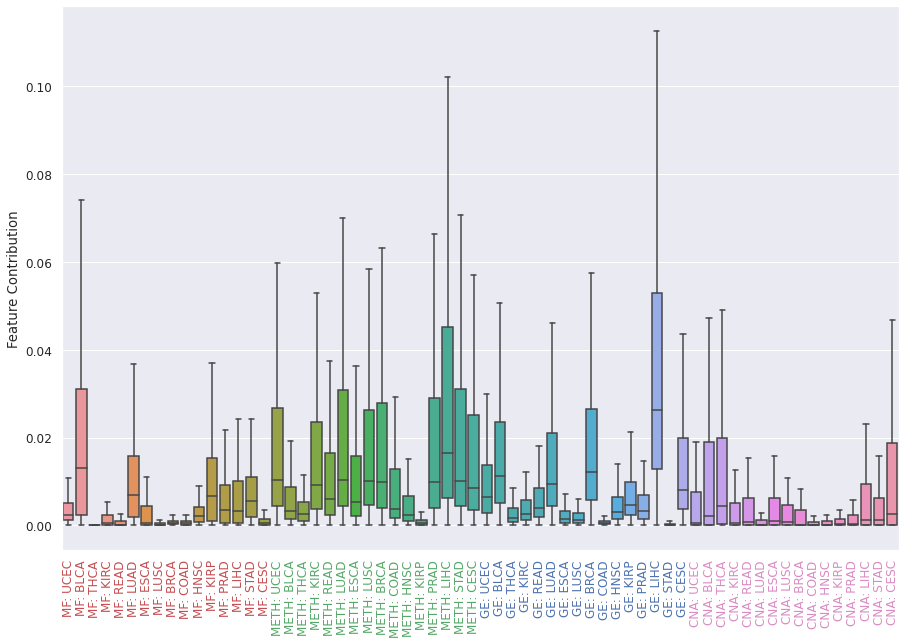

In [153]:
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mplt
from tqdm import tqdm
    
    
number_of_input_nodes = batch.x.shape[0]

#Compute idx for cancer and non-cancer genes
cancer_idx = []
for idx,label in enumerate(final_y[number_of_input_nodes:]):
    if(label==1):
        cancer_idx.append(idx)
         
print(len(cancer_idx))



avg_node_feat_mask = torch.zeros(1,64)
for cnt,idx in enumerate(tqdm(cancer_idx)):
    output_idx = number_of_input_nodes + idx #TARGET NODE GENE to explain
    target = int(final_y[output_idx])
    if(target==0):
        label_gene = "non-cancer"
    else:
        label_gene = "cancer"
        
    with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_{label_gene}.pkl","rb") as handle:
        node_feat_mask = pickle.load(handle).squeeze(0)
        
    node_feat_mask = node_feat_mask.abs()
    ig_attr_node = node_feat_mask.abs().sum(dim=1)
    ig_attr_node /= ig_attr_node.max()
    values,indices = ig_attr_node.sort(descending=True)
    

    top_node_feat = torch.mean(node_feat_mask[indices[:5]],dim=0)
    avg_node_feat_mask = torch.cat((avg_node_feat_mask,top_node_feat.unsqueeze(dim=0)),dim=0) #feat_contr of meta node

    #avg_node_feat_mask = torch.cat((avg_node_feat_mask,node_feat_mask[output_idx].unsqueeze(dim=0)),dim=0) #feat_contr of meta node

sb.reset_orig()

#sb.set_style("whitegrid")
sb.set_context("paper")
sb.set(font_scale = 1.1)

fig, ax = plt.subplots(figsize=(15, 10))

avg_node_feat_mask = avg_node_feat_mask[1:]
df = pd.DataFrame(avg_node_feat_mask)
ax = sb.boxplot(data=df,showfliers=False)
ax.set_xticks(range(len(features_order))) # <--- set the ticks first
ax.set_xticklabels(features_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

my_colors = sb.color_palette()  
for i,ticklabel in enumerate(plt.gca().get_xticklabels()):
    if(i<16):
        idx =3
    elif(i>=16 and i<32):
        idx = 2
    elif(i>=32 and i<48):
        idx=0
    else:
        idx = 6
    ticklabel.set_color(my_colors[idx])

plt.ylabel("Feature Contribution")
plt.savefig(f"{model_dir}/explain/boxplot_feature_contrib_kcg.pdf",bbox_inches="tight")
plt.show()



## BOXPLOT Of each feature type across KCG

In [249]:
features_order

array(['MF: UCEC', 'MF: BLCA', 'MF: THCA', 'MF: KIRC', 'MF: READ',
       'MF: LUAD', 'MF: ESCA', 'MF: LUSC', 'MF: BRCA', 'MF: COAD',
       'MF: HNSC', 'MF: KIRP', 'MF: PRAD', 'MF: LIHC', 'MF: STAD',
       'MF: CESC', 'METH: UCEC', 'METH: BLCA', 'METH: THCA', 'METH: KIRC',
       'METH: READ', 'METH: LUAD', 'METH: ESCA', 'METH: LUSC',
       'METH: BRCA', 'METH: COAD', 'METH: HNSC', 'METH: KIRP',
       'METH: PRAD', 'METH: LIHC', 'METH: STAD', 'METH: CESC', 'GE: UCEC',
       'GE: BLCA', 'GE: THCA', 'GE: KIRC', 'GE: READ', 'GE: LUAD',
       'GE: ESCA', 'GE: LUSC', 'GE: BRCA', 'GE: COAD', 'GE: HNSC',
       'GE: KIRP', 'GE: PRAD', 'GE: LIHC', 'GE: STAD', 'GE: CESC',
       'CNA: UCEC', 'CNA: BLCA', 'CNA: THCA', 'CNA: KIRC', 'CNA: READ',
       'CNA: LUAD', 'CNA: ESCA', 'CNA: LUSC', 'CNA: BRCA', 'CNA: COAD',
       'CNA: HNSC', 'CNA: KIRP', 'CNA: PRAD', 'CNA: LIHC', 'CNA: STAD',
       'CNA: CESC'], dtype='<U10')

100%|██████████| 887/887 [06:54<00:00,  2.14it/s]


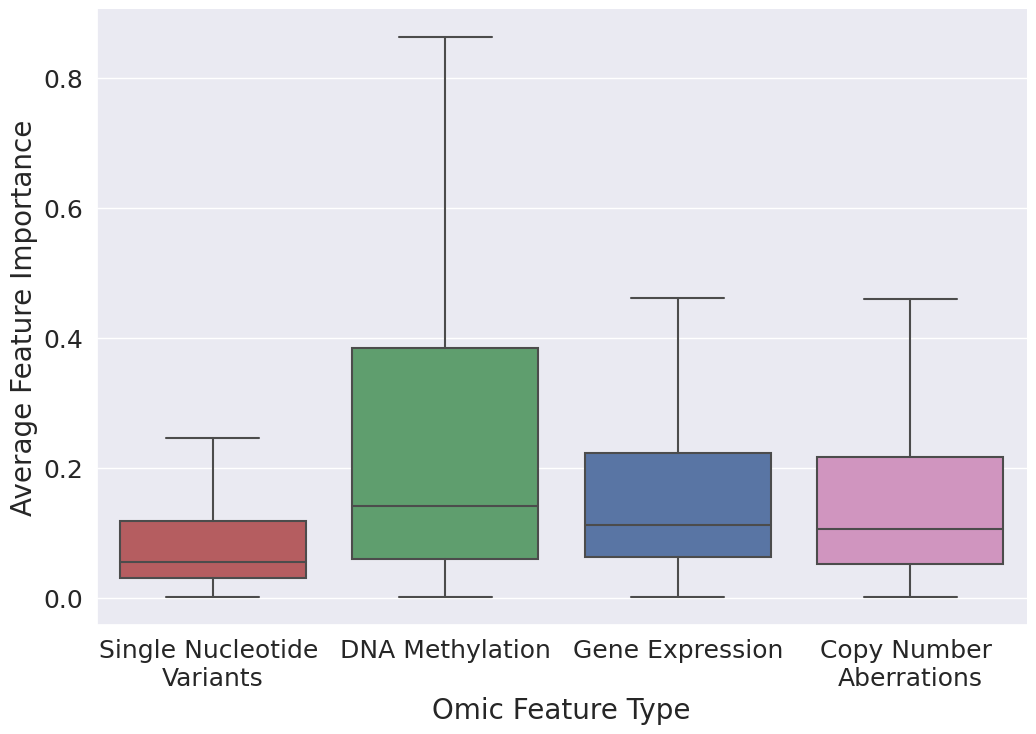

12.0 8.0


<Figure size 1200x800 with 0 Axes>

In [59]:
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm 
import importlib


compute = False
if(compute==True):
    avg_node_feat_mask = torch.zeros(1,4)
    for cnt,idx in enumerate(tqdm(cancer_idx)):
        number_of_input_nodes = batch.x.shape[0]
        output_idx = number_of_input_nodes + idx #TARGET NODE GENE to explain
        target = int(final_y[output_idx])
        if(target==0):
            label_gene = "non-cancer"
        else:
            label_gene = "cancer"

        with open(f"{model_dir}/explain/node_feat_mask_explain_{idx}_{label_gene}.pkl","rb") as handle:
            node_feat_mask = pickle.load(handle).squeeze(0)

        node_feat_mask = node_feat_mask.abs()
        ig_attr_node = node_feat_mask.abs().sum(dim=1)
        ig_attr_node /= ig_attr_node.max()
        values,indices = ig_attr_node.sort(descending=True)
        top_node_feat = torch.mean(node_feat_mask[indices[:5]],dim=0)
        #top_node_feat = node_feat_mask[indices[0]]

        top_node_feat = torch.tensor(np.array([torch.sum(top_node_feat[0:16]),torch.sum(top_node_feat[16:32]),torch.sum(top_node_feat[32:48]),torch.sum(top_node_feat[48:])]))

        avg_node_feat_mask = torch.cat((avg_node_feat_mask,top_node_feat.unsqueeze(dim=0)),dim=0) #feat_contr of meta node

        #avg_node_feat_mask = torch.cat((avg_node_feat_mask,node_feat_mask[output_idx].unsqueeze(dim=0)),dim=0) #feat_contr of meta node


#plt.figure(figsize=(12, 12))

fig, ax = plt.subplots(figsize=(12, 8))
sb.set_context("paper")
sb.set(font_scale = 1.1)
BIGGER_SIZE=14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
rcParams['figure.figsize'] = (12,8)

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['xtick.top'] = False
rcParams['ytick.right'] = False

avg_node_feat_mask = avg_node_feat_mask[1:]
df = pd.DataFrame(avg_node_feat_mask)
df = df.rename(columns={0: "Single Nucleotide Variants", 1: "DNA Methylation", 2:"Gene Expression",3:"Copy Number Aberrations"})
my_colors =sb.color_palette()
palette = [my_colors[3],my_colors[2],my_colors[0],my_colors[6]]
sb.boxplot(data=df,showfliers=False,palette=palette,hue_order=["Single Nucleotide Variants","DNA Methylation","Gene Expression","Copy Number Aberrations"])



ax.set_xticks(range(4)) # <--- set the ticks first
ax.set_xticklabels(["Single Nucleotide \nVariants","DNA Methylation","Gene Expression","Copy Number \nAberrations"])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.xlabel("Omic Feature Type",fontsize=20)
plt.ylabel('Average Feature Importance',fontsize=20)

plt.savefig(f"{model_dir}/explain/boxplot_feature_contrib_each_type_kcg.pdf",bbox_inches="tight")
plt.show()
fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)
plt.clf()


In [74]:
#one-over-all t-test
import scipy.stats as stats

# Perform t-test for SNV features against each other type of feature
t_test_result = stats.ttest_ind(df["Single Nucleotide Variants"], df["DNA Methylation"])
print("t-test for SNV vs DNA methylation: ", t_test_result)

t_test_result = stats.ttest_ind(df["Single Nucleotide Variants"], df["Gene Expression"])
print("t-test for SNV vs gene expression: ", t_test_result)

t_test_result = stats.ttest_ind(df["Single Nucleotide Variants"], df["Copy Number Aberrations"])
print("t-test for SNV vs copy number: ", t_test_result)



from scipy.stats import f_oneway, ttest_ind
snv_features = df["Single Nucleotide Variants"]
methylation_features = df["DNA Methylation"]
expression_features = df["Gene Expression"]
cna_features = df["Copy Number Aberrations"]
# Assume snv_features, methylation_features, expression_features, cna_features are lists of feature importance scores

feat_type = {}
feat_type[0]= "Single Nucleotide Variants"
feat_type[1]= "DNA Methylation"
feat_type[2]= "Gene Expression"
feat_type[3]= "Copy Number Aberrations"

f, p = f_oneway(snv_features, methylation_features, expression_features, cna_features)

if p < 0.05:
    print("ANOVA test indicates that there is a significant difference in means across groups")
    for group1 in range(4):
        for group2 in range(group1+1,4):
            t, p = ttest_ind(eval(f"{['snv_features','methylation_features','expression_features','cna_features'][group1]}"),
                             eval(f"{['snv_features','methylation_features','expression_features','cna_features'][group2]}"),
                             equal_var=False)
            if p < 0.05:
                print(f"t-test between group {feat_type[group1]} and group {feat_type[group2]} indicates significant difference (p={p:.4f})")
            else:
                print(f"t-test between group {feat_type[group1]} and group {feat_type[group2]} does NOT indicate significant difference (p={p:.4f})")


t-test for SNV vs DNA methylation:  Ttest_indResult(statistic=-14.801257227373293, pvalue=7.97497079654881e-47)
t-test for SNV vs gene expression:  Ttest_indResult(statistic=-10.470782499617085, pvalue=6.181621141105397e-25)
t-test for SNV vs copy number:  Ttest_indResult(statistic=-9.709995697177531, pvalue=9.41912621385794e-22)
ANOVA test indicates that there is a significant difference in means across groups
t-test between group Single Nucleotide Variants and group DNA Methylation indicates significant difference (p=0.0000)
t-test between group Single Nucleotide Variants and group Gene Expression indicates significant difference (p=0.0000)
t-test between group Single Nucleotide Variants and group Copy Number Aberrations indicates significant difference (p=0.0000)
t-test between group DNA Methylation and group Gene Expression indicates significant difference (p=0.0000)
t-test between group DNA Methylation and group Copy Number Aberrations indicates significant difference (p=0.0000)
t

## Metagraph Analysis - Correlation of edge contribution with number of cancer-gene neighbors

In [150]:
#with open(f"{model_dir}/meta_nodes_neighbors","rb") as handle:
#    meta_nodes_neighbors = pickle.load(handle)
    
    
df = pd.read_table(f"{model_dir}/predictions.tsv")
node_name_to_idx = {}
for idx,name in enumerate(all_node_names):
    node_name_to_idx[name] = idx
    
sorted_df = df.sort_values(by="Prob_pos",ascending=False)
nodes_to_explain = list(sorted_df["Name"])[:100]
predicted_idx = []
for node in nodes_to_explain:
    n = node+"_Meta_Node"
    predicted_idx.append(node_name_to_idx[n])

predicted_idx = [x - number_of_input_nodes for x in predicted_idx]


In [135]:
with open(f"{model_dir}/explain/edge_mask_explain_{cancer_idx[-1]}_cancer.pkl","rb") as handle:
        edge_mask_explain = pickle.load(handle).squeeze(0)
print(cancer_idx[-1],edge_mask_explain)
torch.nonzero(edge_mask_explain)


22578 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64,
       grad_fn=<SqueezeBackward1>)


tensor([[ 87965],
        [202832]])

In [60]:

import math
from tqdm import tqdm

graph_explain = {} #dict with networks as keys, and values the edge contributions
for c_idx in tqdm(cancer_idx):
    with open(f"{model_dir}/explain/edge_mask_explain_{c_idx}_cancer.pkl","rb") as handle:
        edge_mask_explain = pickle.load(handle).squeeze(0)

    gene_name = all_node_names[c_idx+number_of_input_nodes].split("_",1)[0]
    
    ig_attr_edge = edge_mask_explain.squeeze(0).abs()
    ig_attr_edge /= ig_attr_edge.max()
    sorted_values,indices = ig_attr_edge.sort(descending=True)
    #for idx,v in enumerate(sorted_values[:6]): # we use 6 datasets-graphs
    non_zero_idx = np.nonzero(edge_mask_explain)
    not_added_names = ["CPDB","IREF_2015","PCNET","STRING","MULTINET","IREF"]
    non_zero_idx = meta_edge_index[0,non_zero_idx]
    for idx in non_zero_idx:
        if(idx>=number_of_input_nodes):
            continue
        if(all_node_names[idx].split("_",1)[0]!=gene_name):
            continue
        name = all_node_names[idx].split("_",1)[-1]
        if(name in graph_explain):
            graph_explain[name].append(ig_attr_edge[idx].item())
        else:
            graph_explain[name] = [ig_attr_edge[idx].item()]
        not_added_names.remove(name)
    for name in not_added_names:
        if(name in graph_explain):
            graph_explain[name].append(0) 
        else:
            graph_explain[name]=[0] 

key_order = ["CPDB", "MULTINET", "PCNET", "STRING", "IREF", "IREF_2015"]
graph_explain = {k : graph_explain[k] for k in key_order}

graph_explain["Multinet"] = graph_explain.pop("MULTINET")
graph_explain["PCNet"] = graph_explain.pop("PCNET")
graph_explain["STRING-db"] = graph_explain.pop("STRING")
graph_explain["Iref"] = graph_explain.pop("IREF")
graph_explain["Iref(2015)"] = graph_explain.pop("IREF_2015")



100%|██████████| 887/887 [01:15<00:00, 11.73it/s]


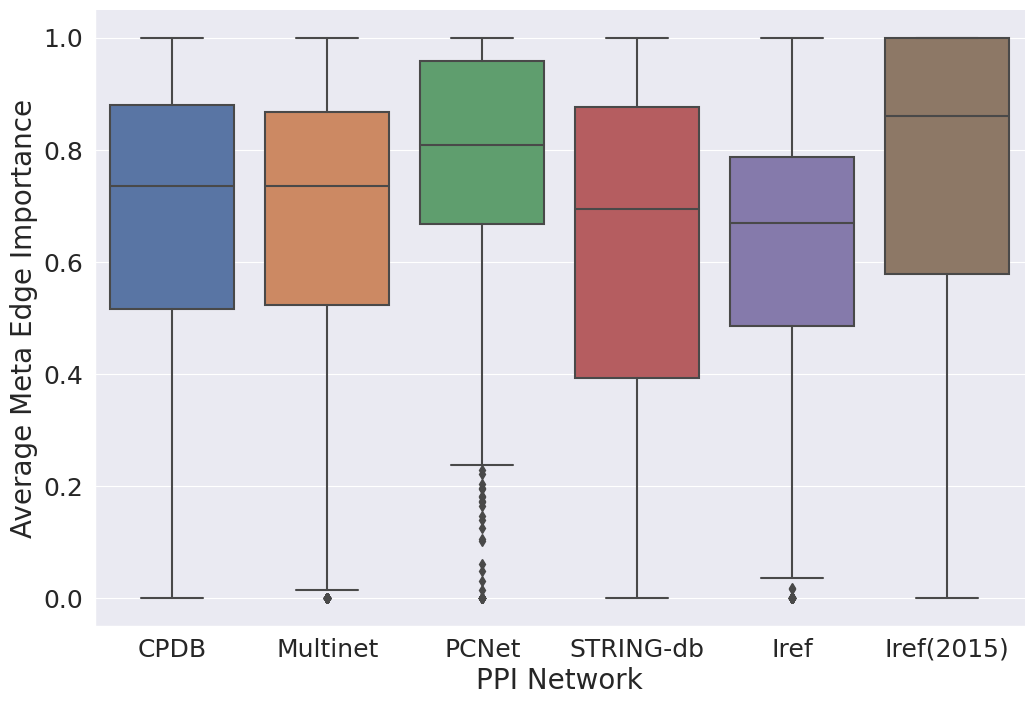

12.0 8.0


<Figure size 1200x800 with 0 Axes>

In [61]:
sb.set_context("paper")
#sb.set_style("whitegrid")
BIGGER_SIZE=14
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

rcParams['figure.figsize'] = (12,8)

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['xtick.top'] = False
rcParams['ytick.right'] = False
fig, ax = plt.subplots(figsize=(12, 8))



df_graph = pd.DataFrame(graph_explain)
sb.set(font_scale = 1.5)

sb.boxplot(data=df_graph,hue_order=["CPDB","Multinet","PCNet","STRING-db","Iref","Iref(2015)"])

#ax.set_xticks(range(len(features_order))) # <--- set the ticks first
#ax.set_xticklabels(features_order)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize = 18 )
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.xlabel("PPI Network",fontsize=20)
plt.ylabel("Average Meta Edge Importance",fontsize=20)
plt.savefig(f"{model_dir}/explain/boxplot_meta_edge_feature_contr.pdf",bbox_inches="tight")
plt.show()

fig_width, fig_height = plt.gcf().get_size_inches()
print(fig_width, fig_height)
plt.clf()


In [95]:
#ANOVA test
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df_graph[df_graph['CPDB']>=0.01]['CPDB'], df_graph[df_graph['Multinet']>=0.01]['Multinet'], df_graph[df_graph['PCNet']>=0.001]['PCNet'], df_graph[df_graph['STRING-db']>=0.001]['STRING-db'], df_graph[df_graph['Iref']>=0.01]['Iref'],df_graph[df_graph["Iref(2015)"]>=0.01]['Iref(2015)'])
#fvalue, pvalue = stats.f_oneway(df['CPDB'], df['Multinet'], df['PCNet'], df['STRING-db'], df['Iref'],df["Iref(2015)"])

print(fvalue, pvalue)

#t-test
stats.ttest_ind(df_graph[df_graph['Iref(2015)']>=0.01]['Iref(2015)'],df_graph[df_graph['Iref']>=0.01]['Iref'])


64.87445435904554 1.2504469614105396e-65


Ttest_indResult(statistic=15.512997047360267, pvalue=1.3740354074412559e-50)

In [93]:
#t_test on the models emgnn,emogi for pcnet
import scipy 
emgnn_mean = 0.761
emgnn_std = 0.001
emogi_mean = 0.745
emogi_std = 0.002
 
# create a function that takes as input the mean and the std of two models and perform a t-test to check if the two models are significantly different
def t_test_mean_std(mean1, std1, mean2, std2, n1, n2):
    # calculate the t statistic
    t_stat = (mean1 - mean2) / math.sqrt(std1**2/n1 + std2**2/n2)
    # degrees of freedom
    df = (std1**2/n1 + std2**2/n2)**2 / ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))
    # calculate the critical value
    cv = stats.t.ppf(1.0 - 0.05, df)
    # calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

t_test_mean_std(emgnn_mean,emgnn_std,emogi_mean,emogi_std,5,5)

(16.000000000000014,
 5.882352941176471,
 1.9501625719000588,
 4.5058369111394825e-06)

In [17]:
#for each gene , find the number of cancer gene neighbor in each graph, normalize by degree
from tqdm import tqdm
def find_cancer_neighbors(node):
    neighb = list(graph.neighbors(node))
    res = torch.tensor([0])
    counter =0
    for i in neighb:
        if(i==node): #skip self edges
            continue 
        if(i>=number_of_input_nodes): #skip meta edge
            continue
        res+=final_y[i]
        counter +=1
    if(counter==0):
        counter = 1
    #return res.item() / counter
    return res.item() 


graph_cancer_neighbors = {}
for idx in tqdm(cancer_idx):
    neighb = list(graph.in_edges(number_of_input_nodes+idx))
    not_added_names = ["CPDB","IREF_2015","PCNET","STRING","MULTINET","IREF"]
    for s,d in neighb:
        if(s>=number_of_input_nodes): #skip self meta edges
            continue
        name = all_node_names[s].split("_",1)[-1]
        if(name in graph_cancer_neighbors):
            graph_cancer_neighbors[name].append(find_cancer_neighbors(s))
        else:
            graph_cancer_neighbors[name] = [find_cancer_neighbors(s)]
        not_added_names.remove(name)
    for name in not_added_names:
        graph_cancer_neighbors[name].append(0) 
     
key_order = ["CPDB", "MULTINET", "PCNET", "STRING", "IREF", "IREF_2015"]
graph_cancer_neighbors = {k : graph_cancer_neighbors[k] for k in key_order}

graph_cancer_neighbors["Multinet"] = graph_cancer_neighbors.pop("MULTINET")
graph_cancer_neighbors["PCNet"] = graph_cancer_neighbors.pop("PCNET")
graph_cancer_neighbors["STRING-db"] = graph_cancer_neighbors.pop("STRING")
graph_cancer_neighbors["Iref"] = graph_cancer_neighbors.pop("IREF")
graph_cancer_neighbors["Iref(2015)"] = graph_cancer_neighbors.pop("IREF_2015")


100%|██████████| 887/887 [00:02<00:00, 360.37it/s]


In [20]:
with open(f"{model_dir}/graph_cancer_neighbors_unormalized.pkl","wb") as handle:
    pickle.dump(graph_cancer_neighbors,handle)
print(model_dir)


./results/my_models/GCN_['IREF_2015', 'PCNET', 'IREF', 'STRING', 'MULTINET', 'CPDB']_2023_01_02_16_59_31


<Figure size 1200x800 with 0 Axes>

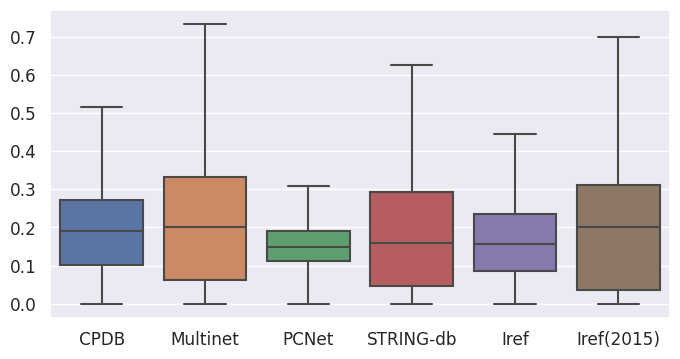

-0.12140649383759473
PearsonRResult(statistic=0.14558067893177964, pvalue=1.3437372400167995e-05)


In [13]:
from scipy.stats import pearsonr
import math 
from scipy.stats import kendalltau

#sb.set_style("whitegrid")
sb.set_context("paper")
sb.set(font_scale = 1.1)

fig, ax = plt.subplots(figsize=(8, 4))

df = pd.DataFrame(graph_cancer_neighbors)
ax = sb.boxplot(data=df,showfliers=False)
#ax.set_xticks(range(len(features_order))) # <--- set the ticks first
#ax.set_xticklabels(features_order)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig(f"{model_dir}/explain/boxplot_cancer_neighbors.pdf",bbox_inches="tight")
plt.show()
df.describe()

graph_explain["CPDB"] = np.nan_to_num(graph_explain["CPDB"])
graph_explain["Multinet"] = np.nan_to_num(graph_explain["Multinet"])
graph_explain["PCNet"] = np.nan_to_num(graph_explain["PCNet"])
graph_explain["STRING-db"] = np.nan_to_num(graph_explain["STRING-db"])
graph_explain["Iref"] = np.nan_to_num(graph_explain["Iref"])
graph_explain["Iref(2015)"] = np.nan_to_num(graph_explain["Iref(2015)"])

list_explain = np.array([graph_explain["CPDB"],graph_explain["Multinet"],graph_explain["PCNet"],graph_explain["STRING-db"],graph_explain["Iref"],graph_explain["Iref(2015)"]])
list_explain_sorted = np.argsort(list_explain[::-1],axis=0)

list_cancer_neighb = np.array([graph_cancer_neighbors["CPDB"],graph_cancer_neighbors["Multinet"],graph_cancer_neighbors["PCNet"],graph_cancer_neighbors["STRING-db"],graph_cancer_neighbors["Iref"],graph_cancer_neighbors["Iref(2015)"]])
list_cancer_neighb_sorted = np.argsort(list_cancer_neighb[::-1],axis=0)

total_corr = []
for i in range(list_cancer_neighb.shape[1]):
    corr, _ = kendalltau(list_cancer_neighb[:,i], list_cancer_neighb_sorted[:,i])
    if(math.isnan(corr)):
        continue
    total_corr.append(corr)
              
print(np.mean(np.array(total_corr)))
print(pearsonr(graph_explain["STRING-db"],graph_cancer_neighbors["STRING-db"]))


In [14]:
import seaborn as sns
import pickle

print(model_dir)


print(graph_explain)
with open(f"{model_dir}/graph_explain.pkl","wb") as handle:
    pickle.dump(graph_explain,handle)
    
with open(f"{model_dir}/graph_cancer_neighbors.pkl","wb") as handle:
    pickle.dump(graph_cancer_neighbors,handle)

gene_names = [all_node_names[i+number_of_input_nodes] for i in cancer_idx]

with open(f"{model_dir}/gene_names_cancer.pkl","wb") as handle:
    pickle.dump(gene_names,handle)
    
print(len(cancer_idx),len(graph_explain["CPDB"]),gene_names) 

## CLUSTER THE SAMPLES BASED ON THE STD of feature importance across the graphs
all_samples = np.array([graph_explain["CPDB"],graph_explain["Multinet"],graph_explain["PCNet"],graph_explain["STRING-db"],graph_explain["Iref"],graph_explain["Iref(2015)"]])
# calculate std values for each sample across all features
all_samples = np.transpose(all_samples)

all_samples = np.nan_to_num(all_samples)
std_values = []
for sample in all_samples:
    non_zero = sample[np.where(sample!=0)]
    if(len(non_zero)==0):
        std_values.append(0)
    else:
        std_values.append(np.std(non_zero))
# plot histogram of std values
plt.hist(std_values, bins=20)
plt.xlabel("std")
plt.ylabel("frequency")
plt.show()

# calculate threshold using mean and std
mean_std = np.mean(std_values)
std_std = np.std(std_values)
threshold = mean_std + 2*std_std

print("threshold",threshold)
# assign samples to clusters based on threshold
# find indices of samples in cluster1 and cluster2
indices_cluster1 = np.where(std_values >= threshold)[0]
indices_cluster2 = np.where(std_values < threshold)[0]

feat_import_cluster1= []
for s1 in indices_cluster1:
    feat_import_cluster1.append(all_node_names[cancer_idx[s1]+number_of_input_nodes].split("_")[0])
    
    
    
c_all_samples = np.array([graph_cancer_neighbors["CPDB"],graph_cancer_neighbors["Multinet"],graph_cancer_neighbors["PCNet"],graph_cancer_neighbors["STRING-db"],graph_cancer_neighbors["Iref"],graph_cancer_neighbors["Iref(2015)"]])
# calculate std values for each sample across all features
c_all_samples = np.transpose(c_all_samples)

std_values = []
for sample in c_all_samples:
    non_zero = sample[np.where(sample!=0)]
    if(len(non_zero)==0):
        std_values.append(0)
    else:
        std_values.append(np.std(non_zero))

# plot histogram of std values
plt.hist(std_values, bins=20)
plt.xlabel("std")
plt.ylabel("frequency")
plt.show()

# calculate threshold using mean and std
mean_std = np.mean(std_values)
std_std = np.std(std_values)
threshold = mean_std + 2*std_std

print("threshold",threshold)
# assign samples to clusters based on threshold
# find indices of samples in cluster1 and cluster2
c_indices_cluster1 = np.where(std_values >= threshold)[0]
c_indices_cluster2 = np.where(std_values < threshold)[0]

cancer_neighbors_cluster1= []

for s1 in indices_cluster1:
    cancer_neighbors_cluster1.append(all_node_names[cancer_idx[s1]+number_of_input_nodes].split("_")[0])
    
    
print(feat_import_cluster1,"\nCancer Neighbors",cancer_neighbors_cluster1)

common_genes = list(set(feat_import_cluster1).intersection(cancer_neighbors_cluster1))
common_genes_ids = list(set(indices_cluster1).intersection(c_indices_cluster1))

print("OVERLAP",common_genes_ids)
networks = ["CPDB","Multinet","PCNet","STRING-db","Iref","Iref(2015)"]
common_df = pd.DataFrame(columns=["Cancer_Neighbors","Meta_Edge_Importance","Gene","Network"])
counter = 0 
for cg in common_genes_ids:
    #print(all_samples[cg],c_all_samples[cg])
    print(all_node_names[cancer_idx[cg]+number_of_input_nodes].split("_")[0])
    for i in range(6):
        Cancer_Neighbors = c_all_samples[cg][i]
        Meta_Edge_Importance = all_samples[cg][i]
        Gene = all_node_names[cancer_idx[cg]+number_of_input_nodes].split("_")[0]
        Network = networks[i]
        common_df.loc[counter] = [Cancer_Neighbors,Meta_Edge_Importance,Gene,Network]
        counter+=1
    
    
sns.scatterplot(data=common_df, x="Cancer_Neighbors", y="Meta_Edge_Importance",hue="Gene",style="Network",s=100)
plt.savefig("./scatter_common.pdf",bbox_inches="tight")
plt.show()
print(common_df)

./results/my_models/GCN_['IREF_2015', 'PCNET', 'IREF', 'STRING', 'MULTINET', 'CPDB']_2023_01_02_16_59_31
{'CPDB': [0.2029399777939948, 0.6136418610555173, 0.4721264598659146, 0.7359876298620107, 0.6220503103471997, 0.7751759480737724, 1.0, 0.708288677350594, 0.6164139135264007, 0.699021571149625, 0.73806827418668, 0.9797921868470534, 0.4186235103847849, 0.7934136607200394, 0.20844960557083897, 0.796381585527559, 0, 0.7635642765065277, 0.8906478137712698, 0.8496741360098238, 0, 0.5373575085868159, 0.7596160245411314, 0.41437698969661574, 0.6502917804498396, 0.7183417684969783, 0.927478369479136, 0.7786909424990648, 0, 0, 0.6622433560379376, 0, 0.6952387136771536, 0.614226927786914, 0.36498164648937576, 0.8691617554086871, 0.9090047662855091, 1.0, 0, 1.0, 0.7874653103559853, 0.8511922178962102, 0.6917104979016174, 0.7467833904277462, 0.8097565808838261, 0.7885979306239469, 0.7380404563525811, 0.9562525585002827, 1.0, 0.9363181515828691, 0.9332391358643627, 0.9185962524688751, 0.786803740

NameError: name 'feofeo' is not defined